In [1]:
!pip install econml

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 163.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 33.4 MB/s eta 0:00:00


In [2]:
!pip install doubleml

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import os

# 辅助函数：加载Excel文件中的所有工作表
def load_excel_sheets(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"文件 {file_path} 在当前目录 {os.getcwd()} 中未找到")
    return pd.read_excel(file_path, sheet_name=None)

# 辅助函数：从日期列中提取年份
def extract_year(date_series):
    date_series = date_series.astype(str)
    parsed_dates = pd.to_datetime(date_series, errors='coerce')
    years = parsed_dates.dt.year
    return years

# 辅助函数：标准化Symbol列（股票代码）
def standardize_symbol(symbol_series):
    return symbol_series.astype(str).str.replace(r'\.[A-Z]{2}$', '', regex=True).str.zfill(6)

# 加载所有数据集
files = {
    'carbon_emission': pd.read_excel('上市公司碳绩效与碳强度（2000-2023年）.xlsx'),
    'esg_index': load_excel_sheets('2009-2024Q1华证指数.xlsx')['ESG年度评级'],
    'company_info': load_excel_sheets('上市公司基本信息.xlsx')['sheet1'],
    'hhi_lerner': load_excel_sheets('上市公司-赫芬达尔指数、勒纳指数（2000-2023年）.xlsx')['Sheet1'],
    'debt_capacity': load_excel_sheets('偿债能力.xlsx')['sheet1'],
    'gdp': load_excel_sheets('分省年度数据-GDP.xlsx')['分省年度数据'],
    'profit': load_excel_sheets('利润表.xlsx')['sheet1'],
    'development': load_excel_sheets('发展能力.xlsx')['sheet1'],
    'env_regulation': load_excel_sheets('环境规制强度.xlsx')['Sheet1'],
    'profitability': load_excel_sheets('盈利能力.xlsx')['sheet1'],
    'relative_value': load_excel_sheets('相对价值指标.xlsx')['sheet1'],
    'governance': load_excel_sheets('管理治理能力.xlsx')['sheet1'],
    'high_pollution': load_excel_sheets('结果高污染.xlsx')['Sheet1'],
    'executive_traits': load_excel_sheets('董监高个人特征.xlsx')['sheet1'],
    'balance_sheet': load_excel_sheets('资产负债表.xlsx')['sheet1']
}

print("成功加载所有数据集")

# 第一步：标准化列名和Symbol格式
# carbon_emission（碳排放数据）
files['carbon_emission'].rename(columns={'id': 'Symbol', 'year': '年份'}, inplace=True)
files['carbon_emission']['Symbol'] = standardize_symbol(files['carbon_emission']['Symbol'])

# esg_index（ESG指数数据）
files['esg_index'].rename(columns={'证券代码': 'Symbol'}, inplace=True)
files['esg_index']['Symbol'] = standardize_symbol(files['esg_index']['Symbol'])
files['esg_index']['年份'] = extract_year(files['esg_index']['评级日期'])
files['esg_index'] = files['esg_index'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['esg_index'] = files['esg_index'].drop(columns=['ShortName'], errors='ignore')

# company_info（公司基本信息）
files['company_info'].rename(columns={'Symbol': 'Symbol', 'PROVINCE': 'Province'}, inplace=True)
files['company_info']['Symbol'] = standardize_symbol(files['company_info']['Symbol'])
files['company_info'] = files['company_info'].drop_duplicates(subset=['Symbol'], keep='first')
files['company_info'] = files['company_info'].drop(columns=['ShortName'], errors='ignore')

# hhi_lerner（赫芬达尔指数和勒纳指数）
files['hhi_lerner'].rename(columns={'股票代码': 'Symbol', '年份': '年份'}, inplace=True)
files['hhi_lerner']['Symbol'] = standardize_symbol(files['hhi_lerner']['Symbol'])
files['hhi_lerner'] = files['hhi_lerner'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['hhi_lerner'] = files['hhi_lerner'].drop(columns=['股票简称'], errors='ignore')

# debt_capacity（偿债能力）
files['debt_capacity'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['debt_capacity']['Symbol'] = standardize_symbol(files['debt_capacity']['Symbol'])
files['debt_capacity'] = files['debt_capacity'][~files['debt_capacity']['Accper'].astype(str).str.contains('统计截止日期')]
files['debt_capacity']['年份'] = extract_year(files['debt_capacity']['Accper'])
files['debt_capacity'] = files['debt_capacity'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['debt_capacity'] = files['debt_capacity'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# gdp（GDP数据，转换为长格式）
gdp_melted = files['gdp'].melt(id_vars=['地区'], 
                               value_vars=[f'GDP{year}' for year in range(2005, 2024)],
                               var_name='年份', value_name='GDP')
gdp_melted['年份'] = gdp_melted['年份'].str.replace('GDP', '').astype(int)
gdp_melted.rename(columns={'地区': 'Province'}, inplace=True)
gdp_melted = gdp_melted.drop_duplicates(subset=['Province', '年份'], keep='first')
files['gdp'] = gdp_melted

# profit（利润表）
files['profit'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['profit']['Symbol'] = standardize_symbol(files['profit']['Symbol'])
files['profit']['年份'] = extract_year(files['profit']['Accper'])
files['profit'] = files['profit'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['profit'] = files['profit'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# development（发展能力）
files['development'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['development']['Symbol'] = standardize_symbol(files['development']['Symbol'])
files['development']['年份'] = extract_year(files['development']['Accper'])
files['development'] = files['development'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['development'] = files['development'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# env_regulation（环境规制强度）
files['env_regulation'].rename(columns={'省份': 'Province', '年份': '年份'}, inplace=True)
files['env_regulation'] = files['env_regulation'].drop_duplicates(subset=['Province', '年份'], keep='first')

# profitability（盈利能力）
files['profitability'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['profitability']['Symbol'] = standardize_symbol(files['profitability']['Symbol'])
files['profitability']['年份'] = extract_year(files['profitability']['Accper'])
files['profitability'] = files['profitability'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['profitability'] = files['profitability'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# relative_value（相对价值指标）
files['relative_value'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['relative_value']['Symbol'] = standardize_symbol(files['relative_value']['Symbol'])
files['relative_value']['年份'] = extract_year(files['relative_value']['Accper'])
files['relative_value'] = files['relative_value'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['relative_value'] = files['relative_value'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# governance（管理治理能力）
files['governance'].rename(columns={'Symbol': 'Symbol'}, inplace=True)
files['governance']['Symbol'] = standardize_symbol(files['governance']['Symbol'])
files['governance']['年份'] = extract_year(files['governance']['Enddate'])
files['governance'] = files['governance'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['governance'] = files['governance'].drop(columns=['ShortName', 'Enddate'], errors='ignore')

# high_pollution（高污染行业）
files['high_pollution'].rename(columns={'证券代码': 'Symbol', 'year': '年份'}, inplace=True)
files['high_pollution']['Symbol'] = standardize_symbol(files['high_pollution']['Symbol'])
files['high_pollution'] = files['high_pollution'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['high_pollution'] = files['high_pollution'].drop(columns=['证券中文简称'], errors='ignore')

# executive_traits（董监高个人特征）
files['executive_traits'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['executive_traits']['Symbol'] = standardize_symbol(files['executive_traits']['Symbol'])
files['executive_traits']['年份'] = extract_year(files['executive_traits']['Reptdt'])
files['executive_traits'] = files['executive_traits'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['executive_traits'] = files['executive_traits'].drop(columns=['Reptdt'], errors='ignore')

# balance_sheet（资产负债表）
files['balance_sheet'].rename(columns={'Stkcd': 'Symbol'}, inplace=True)
files['balance_sheet']['Symbol'] = standardize_symbol(files['balance_sheet']['Symbol'])
files['balance_sheet']['年份'] = extract_year(files['balance_sheet']['Accper'])
files['balance_sheet'] = files['balance_sheet'].drop_duplicates(subset=['Symbol', '年份'], keep='first')
files['balance_sheet'] = files['balance_sheet'].drop(columns=['ShortName', 'Accper', 'Typrep'], errors='ignore')

# 第二步：以碳排放数据集为基础开始合并
merged_data = files['carbon_emission'].copy()
print("初始合并数据集的形状：", merged_data.shape)

# 第三步：按'Symbol'和'年份'合并企业级数据集
firm_level_datasets = ['esg_index', 'hhi_lerner', 'debt_capacity', 'profit', 
                       'development', 'profitability', 'relative_value', 'governance', 
                       'high_pollution', 'executive_traits', 'balance_sheet']

for key in firm_level_datasets:
    try:
        if 'Symbol' in files[key].columns and '年份' in files[key].columns:
            print(f"合并 {key} 之前：")
            print(f"  merged_data['Symbol'].dtype: {merged_data['Symbol'].dtype}")
            print(f"  files['{key}']['Symbol'].dtype: {files[key]['Symbol'].dtype}")
            print(f"  merged_data['年份'].dtype: {merged_data['年份'].dtype}")
            print(f"  files['{key}']['年份'].dtype: {files[key]['年份'].dtype}")
            
            merged_data = pd.merge(merged_data, files[key], on=['Symbol', '年份'], how='left', suffixes=('', f'_{key}'))
            print(f"成功合并 {key}")
            print(f"合并 {key} 后的形状：{merged_data.shape}")
        else:
            print(f"警告：{key} 数据集中没有 'Symbol' 和 '年份' 列，无法进行合并")
    except Exception as e:
        print(f"合并 {key} 时出错：{str(e)}")
        break

# 合并 company_info，仅按 'Symbol' 合并（无年份列）
try:
    if 'Symbol' in files['company_info'].columns:
        merged_data = pd.merge(merged_data, files['company_info'], on=['Symbol'], how='left', suffixes=('', '_company_info'))
        print("成功合并 company_info")
        print(f"合并 company_info 后的形状：{merged_data.shape}")
        print("合并 company_info 后的列名：", merged_data.columns.tolist())
    else:
        print("警告：company_info 数据集中没有 'Symbol' 列，无法进行合并")
except Exception as e:
    print(f"合并 company_info 时出错：{str(e)}")

# 第四步：合并省级数据集（例如 GDP、环境规制强度）
if 'Province' in merged_data.columns:
    try:
        if 'Province' in files['gdp'].columns and '年份' in files['gdp'].columns:
            merged_data = pd.merge(merged_data, files['gdp'][['Province', '年份', 'GDP']], 
                                   on=['Province', '年份'], how='left')
            print("成功合并 GDP 数据")
            print(f"合并 GDP 后的形状：{merged_data.shape}")
        else:
            print("警告：GDP 数据集中没有 'Province' 和 '年份' 列，无法进行合并")
    except Exception as e:
        print(f"合并 GDP 时出错：{str(e)}")

    try:
        if 'Province' in files['env_regulation'].columns and '年份' in files['env_regulation'].columns:
            merged_data = pd.merge(merged_data, files['env_regulation'][['Province', '年份', '环保规制强度']], 
                                   on=['Province', '年份'], how='left')
            print("成功合并环境规制强度数据")
            print(f"合并环境规制强度后的形状：{merged_data.shape}")
        else:
            print("警告：环境规制强度数据集中没有 'Province' 和 '年份' 列，无法进行合并")
    except Exception as e:
        print(f"合并环境规制强度时出错：{str(e)}")
else:
    print("警告：合并数据中未找到 'Province' 列，跳过省级数据合并")

# 第五步：筛选制造业公司（行业代码以 'C' 开头）
if '行业' in merged_data.columns:
    merged_data['IndustryCode'] = merged_data['行业']
    data_mfg = merged_data[merged_data['IndustryCode'].str.startswith('C', na=False)].copy()
    print("成功筛选制造业公司")
    print(f"筛选后的形状：{data_mfg.shape}")
else:
    print("警告：未找到 '行业' 列，无法筛选制造业公司")
    data_mfg = merged_data.copy()

# 第六步：检查合并后的数据集
print("最终合并数据集的形状：", data_mfg.shape)
print("总排放量吨的非空值数量：", data_mfg['总排放量吨'].notna().sum())
if '综合得分' in data_mfg.columns:
    print("综合得分的非空值数量：", data_mfg['综合得分'].notna().sum())
else:
    print("警告：合并数据中未找到 '综合得分' 列")

# 保存合并后的数据集为 CSV 文件（更快），然后转换为 Excel
try:
    # 保存为 CSV
    data_mfg.to_csv('data_mfg_merged.csv', index=False)
    print("已将合并数据保存为 data_mfg_merged.csv")
    # 转换为 Excel
    pd.read_csv('data_mfg_merged.csv').to_excel('data_mfg_merged.xlsx', index=False)
    print("已将 CSV 转换为 Excel：data_mfg_merged.xlsx")
except Exception as e:
    print(f"保存文件时出错：{str(e)}")

Successfully loaded all datasets
Initial merged data shape: (42191, 8)
Before merging esg_index:
  merged_data['Symbol'].dtype: object
  files['esg_index']['Symbol'].dtype: object
  merged_data['年份'].dtype: int64
  files['esg_index']['年份'].dtype: float64
Merged esg_index successfully
Shape after merging esg_index: (42191, 22)
Before merging hhi_lerner:
  merged_data['Symbol'].dtype: object
  files['hhi_lerner']['Symbol'].dtype: object
  merged_data['年份'].dtype: int64
  files['hhi_lerner']['年份'].dtype: float64
Merged hhi_lerner successfully
Shape after merging hhi_lerner: (42191, 30)
Before merging debt_capacity:
  merged_data['Symbol'].dtype: object
  files['debt_capacity']['Symbol'].dtype: object
  merged_data['年份'].dtype: int64
  files['debt_capacity']['年份'].dtype: float64
Merged debt_capacity successfully
Shape after merging debt_capacity: (42191, 36)
Before merging profit:
  merged_data['Symbol'].dtype: object
  files['profit']['Symbol'].dtype: object
  merged_data['年份'].dtype: int

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import mstats

# 加载制造业数据集
# 占位符：请替换为您的实际文件路径
data_mfg = pd.read_excel('data_mfg_merged.xlsx')
print("加载的数据集形状：", data_mfg.shape)

# 第一步：为 ESG 评级（综合评级）分配数值
esg_mapping = {
    'C': 1, 'CC': 2, 'CCC': 3, 'B': 4, 'BB': 5,
    'BBB': 6, 'A': 7, 'AA': 8, 'AAA': 9
}
data_mfg['ESG'] = data_mfg['综合评级'].map(esg_mapping)
print("已为 ESG 评级分配数值：")
print(data_mfg['ESG'].value_counts())

# 第二步：计算新的控制变量，检查是否存在无穷大值
# Size（总资产的对数）
data_mfg['Size'] = np.log(data_mfg['A001000000'] + abs(data_mfg['A001000000'].min()) + 1)

# ROA（净资产收益率 = 净利润 / 总资产） - 避免除以零
data_mfg['ROA'] = data_mfg['B001101000'] / data_mfg['A001000000']
data_mfg['ROA'] = data_mfg['ROA'].replace([np.inf, -np.inf], np.nan)

# Lev（资产负债率 = 总负债 / 总资产） - 避免除以零
data_mfg['Lev'] = data_mfg['A002000000'] / data_mfg['A001000000']
data_mfg['Lev'] = data_mfg['Lev'].replace([np.inf, -np.inf], np.nan)

# 第三步：选择关键数值列进行缺失值填补，包括所有 DML 列和 Boardsize
dml_columns = ['ESG', '碳强度', 'Size', 'ROA', 'Lev', 'Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B']
additional_columns = ['年份', '综合得分', 'E得分', 'S得分', 'G得分', 'GDP', '环保规制强度']
key_numerical_cols = list(set(dml_columns + additional_columns))
print("用于填补的关键数值列：", key_numerical_cols)

# 将关键列中的无穷大值替换为 NaN
for col in key_numerical_cols:
    if col in data_mfg.columns:
        data_mfg[col] = data_mfg[col].replace([np.inf, -np.inf], np.nan)

# 第四步：使用随机森林（IterativeImputer）进行缺失值填补
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=5, random_state=42),
    max_iter=5,
    random_state=42
)
data_mfg[key_numerical_cols] = imputer.fit_transform(data_mfg[key_numerical_cols])
print("已使用随机森林完成缺失值填补")

# 检查填补后的缺失值情况
print("填补后碳强度的非空值数量：", data_mfg['碳强度'].notna().sum())
print("填补后 ESG 的非空值数量：", data_mfg['ESG'].notna().sum())
print("填补后综合得分的非空值数量：", data_mfg['综合得分'].notna().sum())
print("填补后 Boardsize 的非空值数量：", data_mfg['Boardsize'].notna().sum())

# 第五步：在填补后计算 log_Boardsize
if (data_mfg['Boardsize'] <= 0).any():
    print("警告：Boardsize 包含非正值，添加一个小的常数")
    data_mfg['Boardsize'] = data_mfg['Boardsize'] + abs(data_mfg['Boardsize'].min()) + 1
data_mfg['log_Boardsize'] = np.log(data_mfg['Boardsize'])
print("已计算 log_Boardsize")

# 第六步：对其他偏态变量进行对数变换
cols_to_log = ['碳强度', 'GDP', '环保规制强度']  # 已移除 Boardsize，因为 log_Boardsize 已计算

for col in cols_to_log:
    if col in data_mfg.columns:
        if (data_mfg[col] <= 0).any():
            print(f"警告：{col} 包含非正值，添加一个小的常数")
            data_mfg[col] = data_mfg[col] + abs(data_mfg[col].min()) + 1
        data_mfg[f'log_{col}'] = np.log(data_mfg[col])
        print(f"已对 {col} 应用对数变换")
    else:
        print(f"警告：数据集中未找到 {col}")

# 第七步：Winsorization 处理异常值
cols_to_winsorize = [f'log_{col}' for col in cols_to_log if f'log_{col}' in data_mfg.columns] + \
                    ['ESG', '赫芬达尔指数', 'ROA', 'F051901B', 'Lev', 'IndDirectorRatio', 'log_Boardsize']

for col in cols_to_winsorize:
    if col in data_mfg.columns:
        data_mfg[col] = mstats.winsorize(data_mfg[col], limits=[0.01, 0.01])
        print(f"已对 {col} 进行 Winsorization 处理")
    else:
        print(f"警告：数据集中未找到 {col}")

# 第八步：检查填补和 Winsorization 后的 ESG 分布
print("填补和 Winsorization 后的 ESG 分布：")
print(data_mfg['ESG'].describe())
print("填补和 Winsorization 后的 ESG 值计数：")
print(data_mfg['ESG'].value_counts().sort_index())

# 第九步：在标准化前创建 ESG 四分位数
quantiles = pd.qcut(data_mfg['ESG'], q=4, duplicates='drop', retbins=True)
bins = quantiles[1]
n_bins = len(bins) - 1
labels = [f'Q{i+1}' for i in range(n_bins)]
data_mfg['esg_quartile'] = pd.qcut(data_mfg['ESG'], q=4, labels=labels, duplicates='drop')
print("已创建 ESG 四分位数：")
print(data_mfg['esg_quartile'].value_counts())

# 第十步：对数值变量进行标准化
numerical_cols = ['年份', 'ESG', 'Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 
                  'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度'] + \
                 [f'log_{col}' for col in cols_to_log if f'log_{col}' in data_mfg.columns]

# 在标准化前检查零方差
for col in numerical_cols:
    if col in data_mfg.columns:
        if data_mfg[col].std() == 0:
            print(f"警告：{col} 的方差为零，从标准化中移除")
            numerical_cols.remove(col)

for col in numerical_cols:
    if col in data_mfg.columns:
        data_mfg[col] = (data_mfg[col] - data_mfg[col].mean()) / data_mfg[col].std()
        print(f"已标准化 {col}")
    else:
        print(f"警告：数据集中未找到 {col}")

# 第十一步：检查 DML 列中的 NaN 值
dml_columns = ['ESG', 'log_碳强度', 'Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B']
print("检查 DML 列中的 NaN 值：")
for col in dml_columns:
    if col in data_mfg.columns:
        nan_count = data_mfg[col].isna().sum()
        print(f"{col} 中的 NaN 数量：{nan_count}")
    else:
        print(f"警告：数据集中未找到 {col}")

# 第十二步：保存预处理后的数据集
try:
    data_mfg.to_csv('data_mfg_preprocessed.csv', index=False)
    print("已将预处理数据保存为 data_mfg_preprocessed.csv")
    data_mfg.to_excel('data_mfg_preprocessed.xlsx', index=False)
    print("已将预处理数据保存为 data_mfg_preprocessed.xlsx")
except Exception as e:
    print(f"保存预处理数据时出错：{str(e)}")

Loaded dataset shape: (33243, 92)
Assigned numerical values to ESG ratings:
ESG
4.0    11896
5.0     7736
3.0     4581
6.0     1646
2.0     1005
1.0      362
7.0      102
8.0        4
Name: count, dtype: int64
Key numerical columns for imputation: ['环保规制强度', 'F051901B', '赫芬达尔指数', '综合得分', 'Lev', 'ROA', 'GDP', 'S得分', 'G得分', 'E得分', 'IndDirectorRatio', '碳强度', 'ESG', '年份', 'Boardsize', 'Size']
Imputation completed using Random Forest
Non-NaN count for 碳强度 after imputation: 33243
Non-NaN count for ESG after imputation: 33243
Non-NaN count for 综合得分 after imputation: 33243
Non-NaN count for Boardsize after imputation: 33243
Calculated log_Boardsize
Applied logarithmic transformation to 碳强度
Applied logarithmic transformation to GDP
Applied logarithmic transformation to 环保规制强度
Winsorized log_碳强度
Winsorized log_GDP
Winsorized log_环保规制强度
Winsorized ESG
Winsorized 赫芬达尔指数
Winsorized ROA
Winsorized F051901B
Winsorized Lev
Winsorized IndDirectorRatio
Winsorized log_Boardsize
ESG distribution after imp

Loaded preprocessed dataset shape: (33243, 101)
Final check for NaNs in DML columns:
NaN count in ESG: 0
NaN count in log_碳强度: 0
NaN count in Size: 0
NaN count in ROA: 0
NaN count in Lev: 0
NaN count in log_Boardsize: 0
NaN count in 赫芬达尔指数: 0
NaN count in IndDirectorRatio: 0
NaN count in F051901B: 0
NaN count in GDP: 0
NaN count in 环保规制强度: 0
DML data object created successfully

Running DML with split ratio 2:1

Running DML with split ratio 4:1

DML Results Summary:

Model: RF_2:1
Average Treatment Effect (ATE): 0.0105
Confidence Interval: [0.0050, 0.0161]

Model: GB_2:1
Average Treatment Effect (ATE): 0.0154
Confidence Interval: [0.0091, 0.0216]

Model: RF_4:1
Average Treatment Effect (ATE): 0.0111
Confidence Interval: [0.0055, 0.0166]

Model: GB_4:1
Average Treatment Effect (ATE): 0.0157
Confidence Interval: [0.0095, 0.0219]


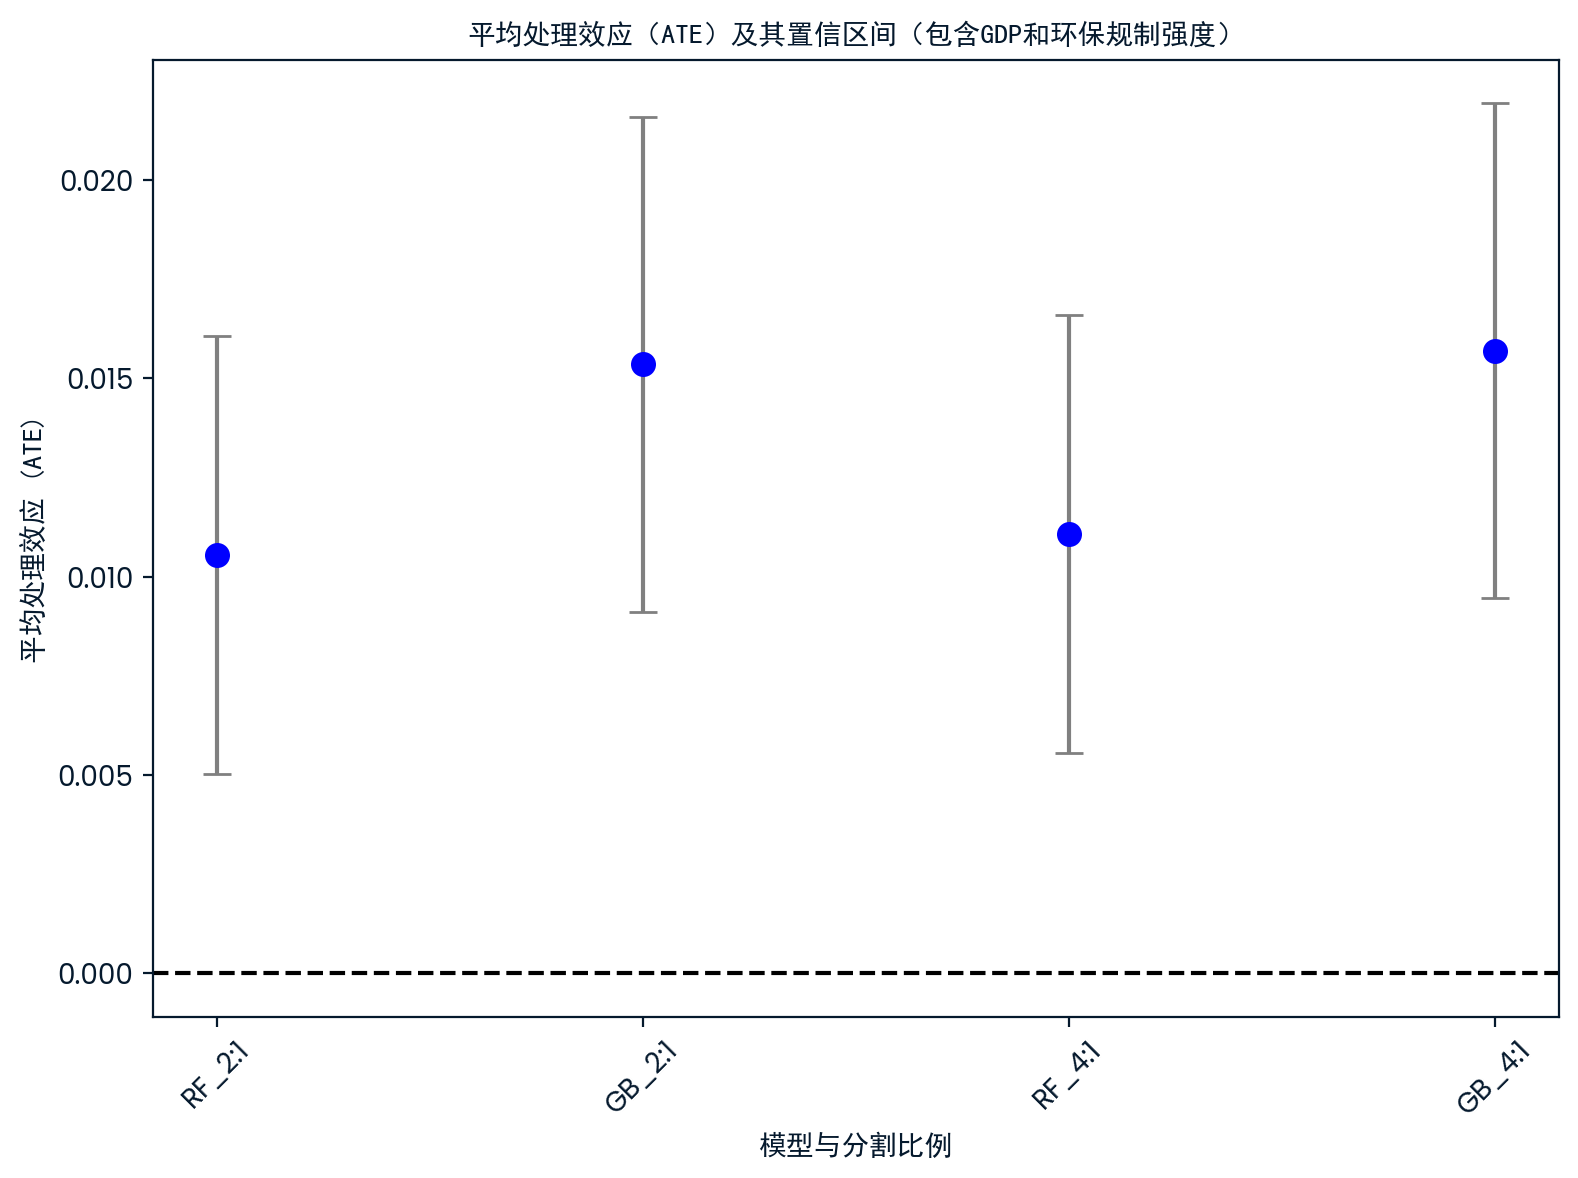

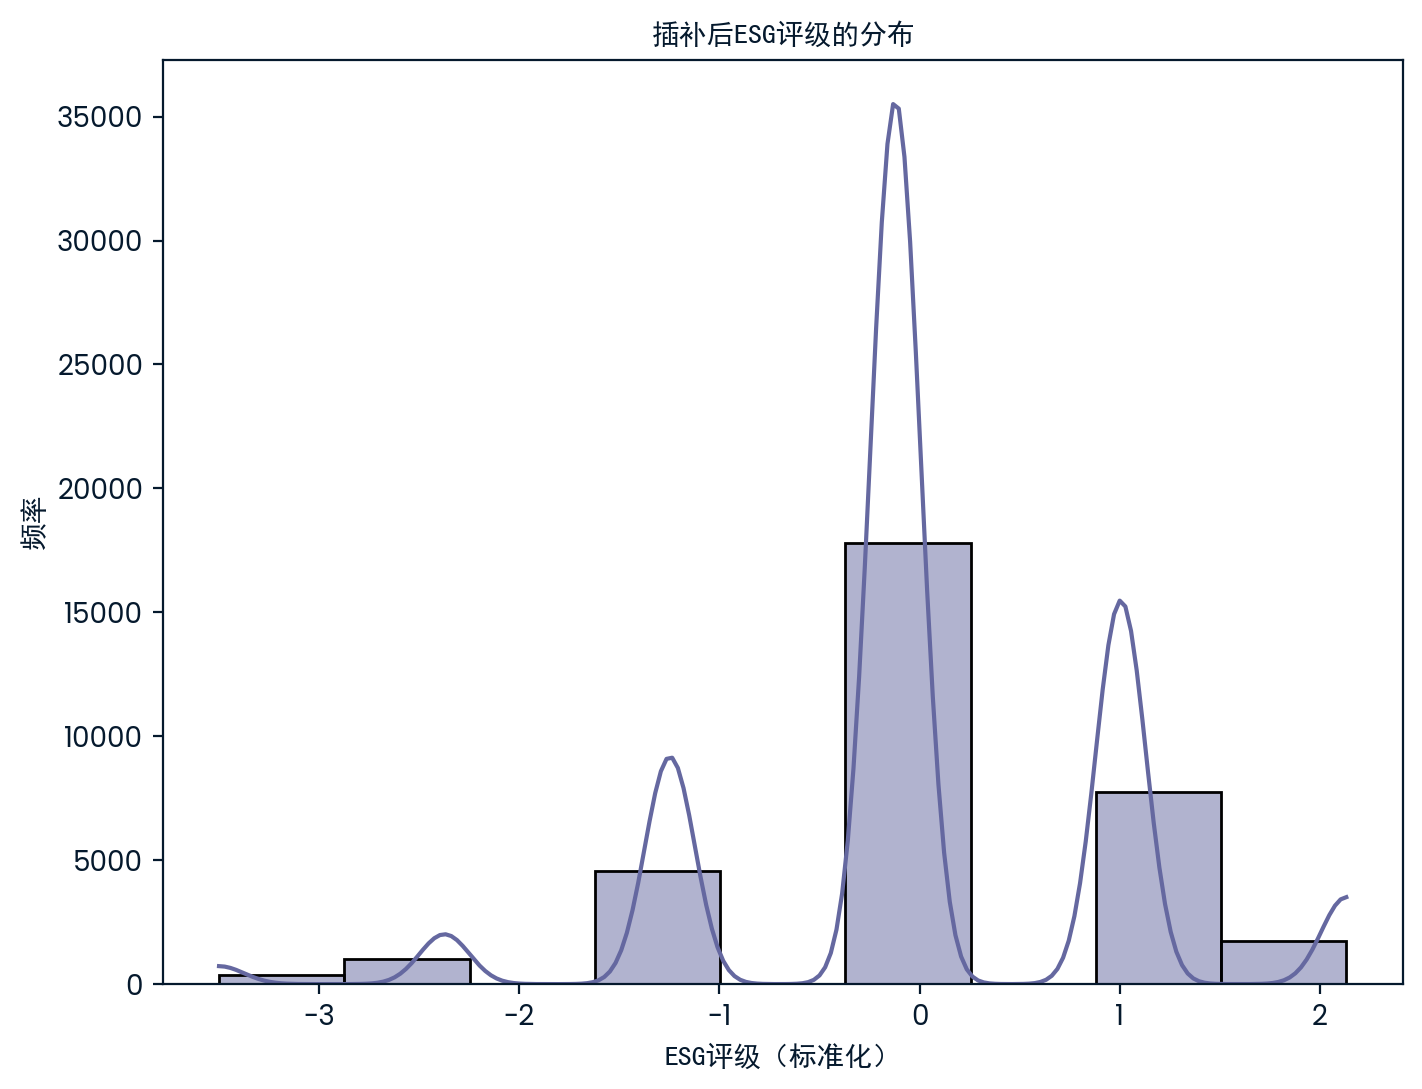

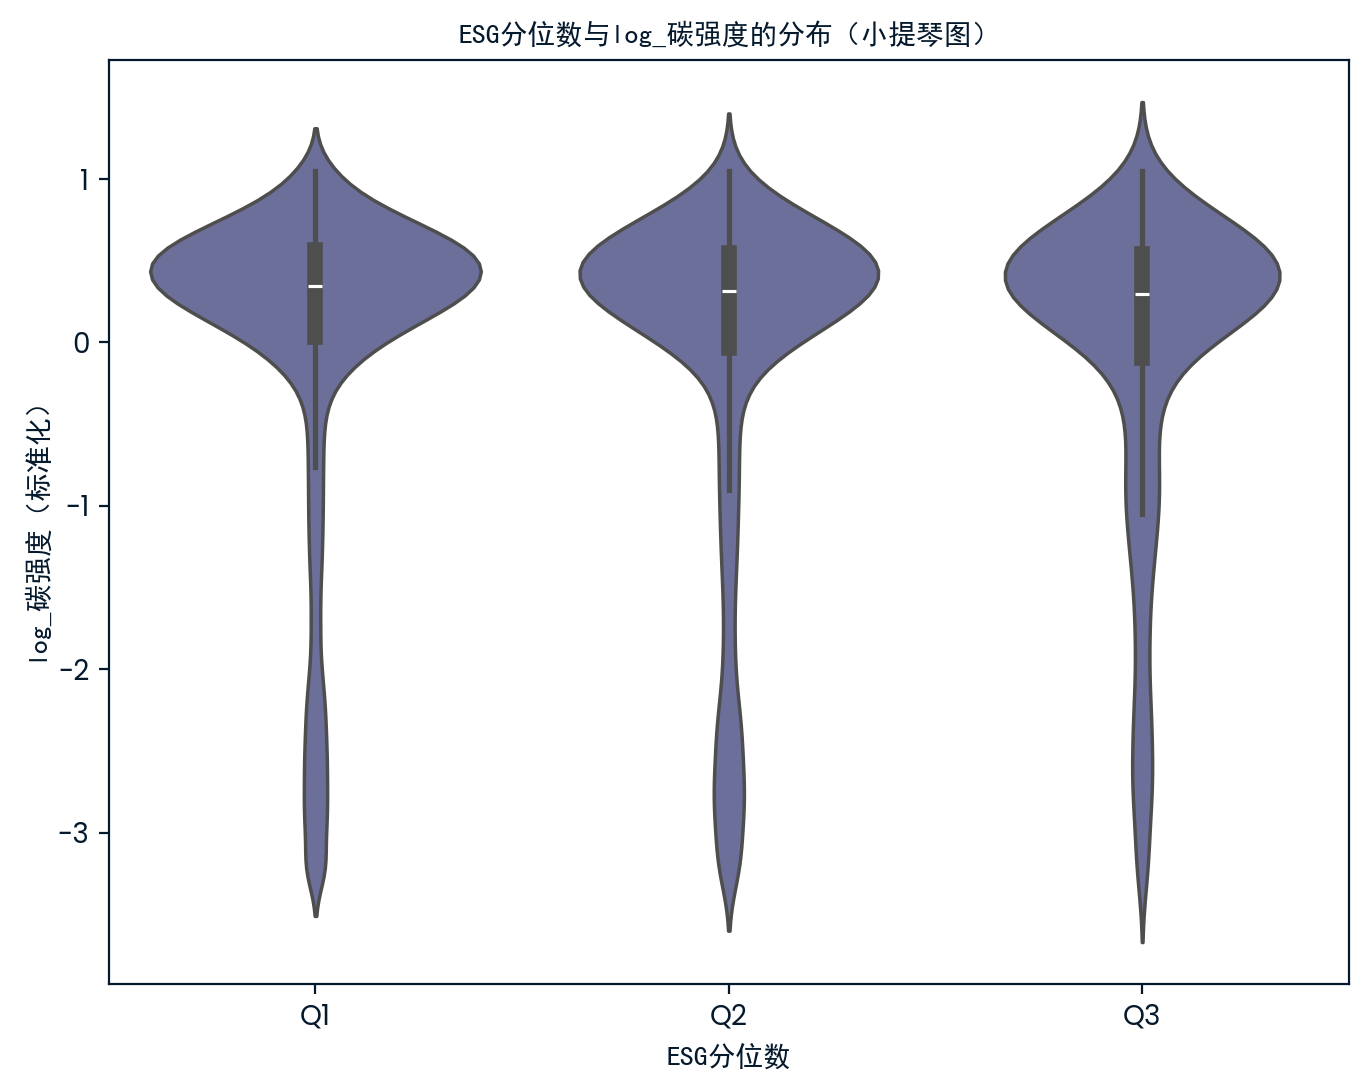

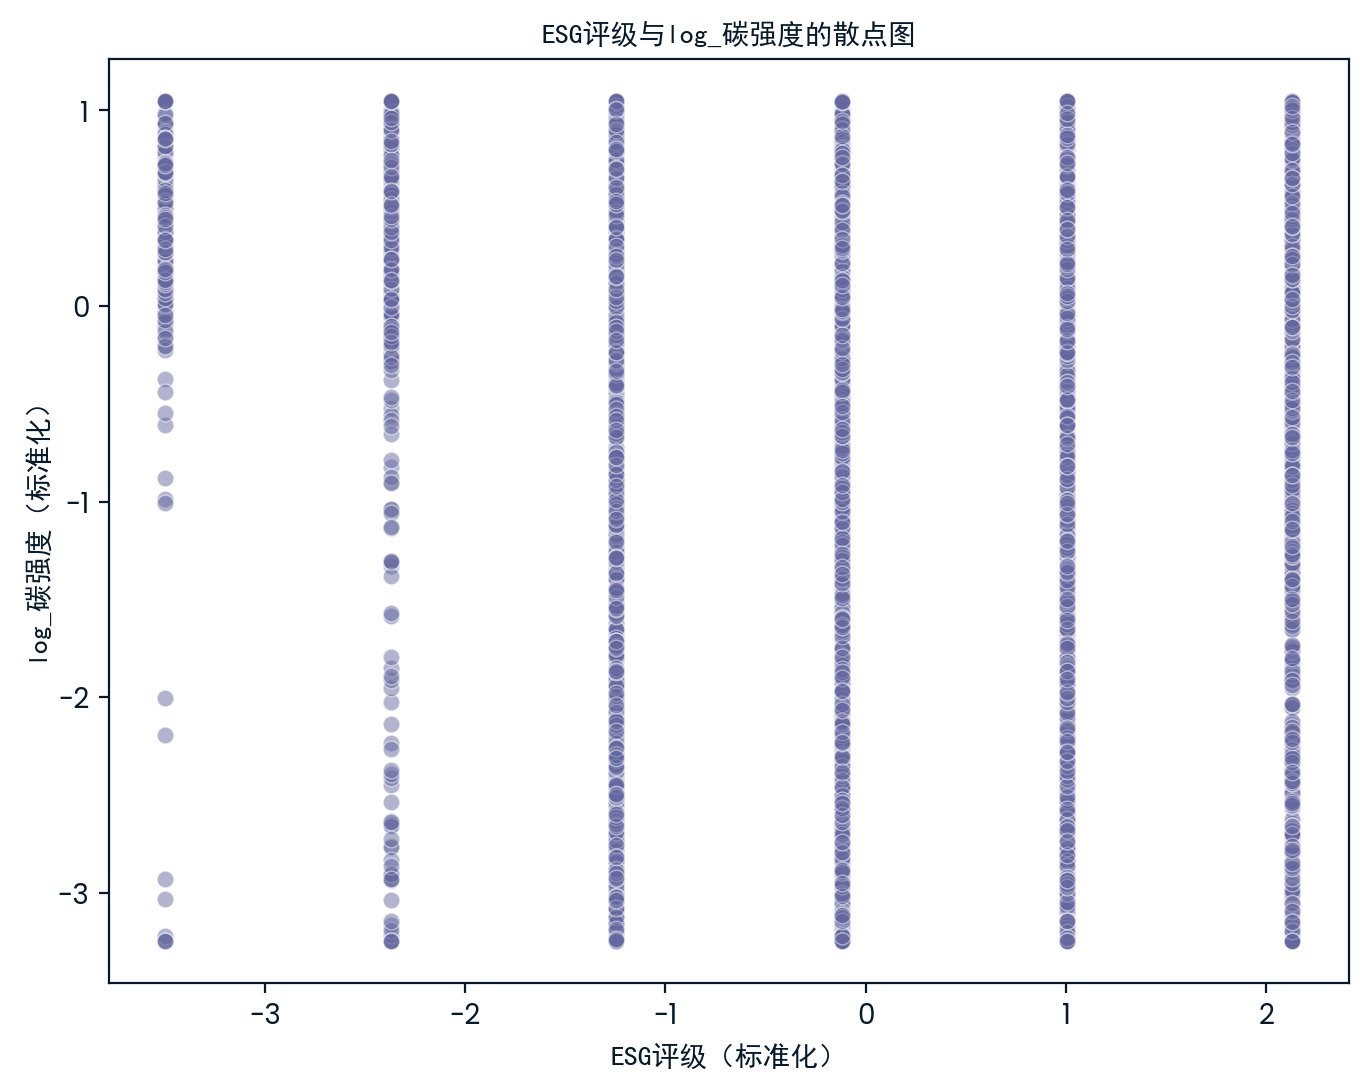

In [6]:
import pandas as pd
import numpy as np
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 设置中文字体以正确显示标签
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 修复负号显示问题

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 加载预处理后的数据集
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')
print("加载的预处理数据集形状：", data_mfg.shape)

# 第一步：为 DML 准备数据
treatment = 'ESG'
outcome = 'log_碳强度'
confounders = ['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']

# 确保所有必需的列都存在
missing_cols = [col for col in [treatment, outcome] + confounders if col not in data_mfg.columns]
if missing_cols:
    raise ValueError(f"缺少的列：{missing_cols}")

# 再次检查 NaN 值（以确保无误）
print("DML 列中 NaN 值的最终检查：")
for col in [treatment, outcome] + confounders:
    nan_count = data_mfg[col].isna().sum()
    print(f"{col} 中的 NaN 数量：{nan_count}")

# 准备 DML 数据对象
data_dml = dml.DoubleMLData(
    data_mfg,
    y_col=outcome,
    d_cols=treatment,
    x_cols=confounders
)
print("成功创建 DML 数据对象")

# 第二步：定义 DML 模型，使用随机森林和梯度提升
ml_l_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ml_m_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ml_l_gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
ml_m_gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# 第三步：使用不同的分割比例运行 DML
split_ratios = {'2:1': 2, '4:1': 4}
results = {}

for ratio_name, n_rep in split_ratios.items():
    print(f"\n使用分割比例 {ratio_name} 运行 DML")
    
    # 随机森林 DML
    dml_plr_rf = dml.DoubleMLPLR(
        data_dml,
        ml_l=ml_l_rf,
        ml_m=ml_m_rf,
        n_folds=5,
        n_rep=n_rep
    )
    dml_plr_rf.fit()
    results[f'RF_{ratio_name}'] = dml_plr_rf
    
    # 梯度提升 DML
    dml_plr_gb = dml.DoubleMLPLR(
        data_dml,
        ml_l=ml_l_gb,
        ml_m=ml_m_gb,
        n_folds=5,
        n_rep=n_rep
    )
    dml_plr_gb.fit()
    results[f'GB_{ratio_name}'] = dml_plr_gb

# 第四步：汇总 DML 结果
print("\nDML 结果汇总：")
for key, dml_obj in results.items():
    ci = dml_obj.confint()
    ci_lower = ci.iloc[0, 0]
    ci_upper = ci.iloc[0, 1]
    print(f"\n模型：{key}")
    print(f"平均处理效应（ATE）：{dml_obj.coef[0]:.4f}")
    print(f"置信区间：[{ci_lower:.4f}, {ci_upper:.4f}]")


# 第五步：关键变量的相关性矩阵，使用正确的中文标签
key_vars = [outcome, treatment] + confounders
corr_matrix = data_mfg[key_vars].corr()

# # 创建热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# 明确设置 x 轴和 y 轴标签为中文列名
ax.set_xticklabels(key_vars, rotation=45, ha='right', fontproperties=font_prop)
ax.set_yticklabels(key_vars, rotation=0, fontproperties=font_prop)

# 第六步：绘制 ATE 及其置信区间
ate_values = [results[key].coef[0] for key in results]
ci_lower = [results[key].confint().iloc[0, 0] for key in results]
ci_upper = [results[key].confint().iloc[0, 1] for key in results]
model_names = list(results.keys())

lower_errors = [ate - ci_lower[i] for i, ate in enumerate(ate_values)]
upper_errors = [ci_upper[i] - ate for i, ate in enumerate(ate_values)]

plt.figure(figsize=(8, 6))
plt.errorbar(model_names, ate_values, yerr=[lower_errors, upper_errors],
             fmt='o', capsize=5, color='blue', ecolor='gray', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.title("平均处理效应（ATE）及其置信区间（包含GDP和环保规制强度）", fontproperties=font_prop)
plt.ylabel("平均处理效应 (ATE)", fontproperties=font_prop)
plt.xlabel("模型与分割比例", fontproperties=font_prop)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ate_plot_with_gdp_regulation.png')
plt.show()

# 第七步：绘制 ESG 评级的分布
plt.figure(figsize=(8, 6))
sns.histplot(data_mfg['ESG'], bins=9, kde=True)
plt.title("插补后ESG评级的分布", fontproperties=font_prop)
plt.xlabel("ESG评级（标准化）", fontproperties=font_prop)
plt.ylabel("频率", fontproperties=font_prop)
plt.savefig('esg_distribution.png')
plt.show()

# 第八步：绘制 ESG 分位数与 log_碳强度的 violin 图
plt.figure(figsize=(8, 6))
sns.violinplot(x='esg_quartile', y='log_碳强度', data=data_mfg)
plt.title("ESG分位数与log_碳强度的分布（小提琴图）", fontproperties=font_prop)
plt.xlabel("ESG分位数", fontproperties=font_prop)
plt.ylabel("log_碳强度（标准化）", fontproperties=font_prop)
plt.savefig('violin_log_carbon_intensity_by_esg_quartile.png')
plt.show()

# 第九步：绘制 ESG 评级与 log_碳强度的散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ESG', y='log_碳强度', data=data_mfg, alpha=0.5)
plt.title("ESG评级与log_碳强度的散点图", fontproperties=font_prop)
plt.xlabel("ESG评级（标准化）", fontproperties=font_prop)
plt.ylabel("log_碳强度（标准化）", fontproperties=font_prop)
plt.savefig('scatter_esg_vs_log_carbon_intensity.png')
plt.show()

Correlation between ESG and E得分: 0.5739851944452576


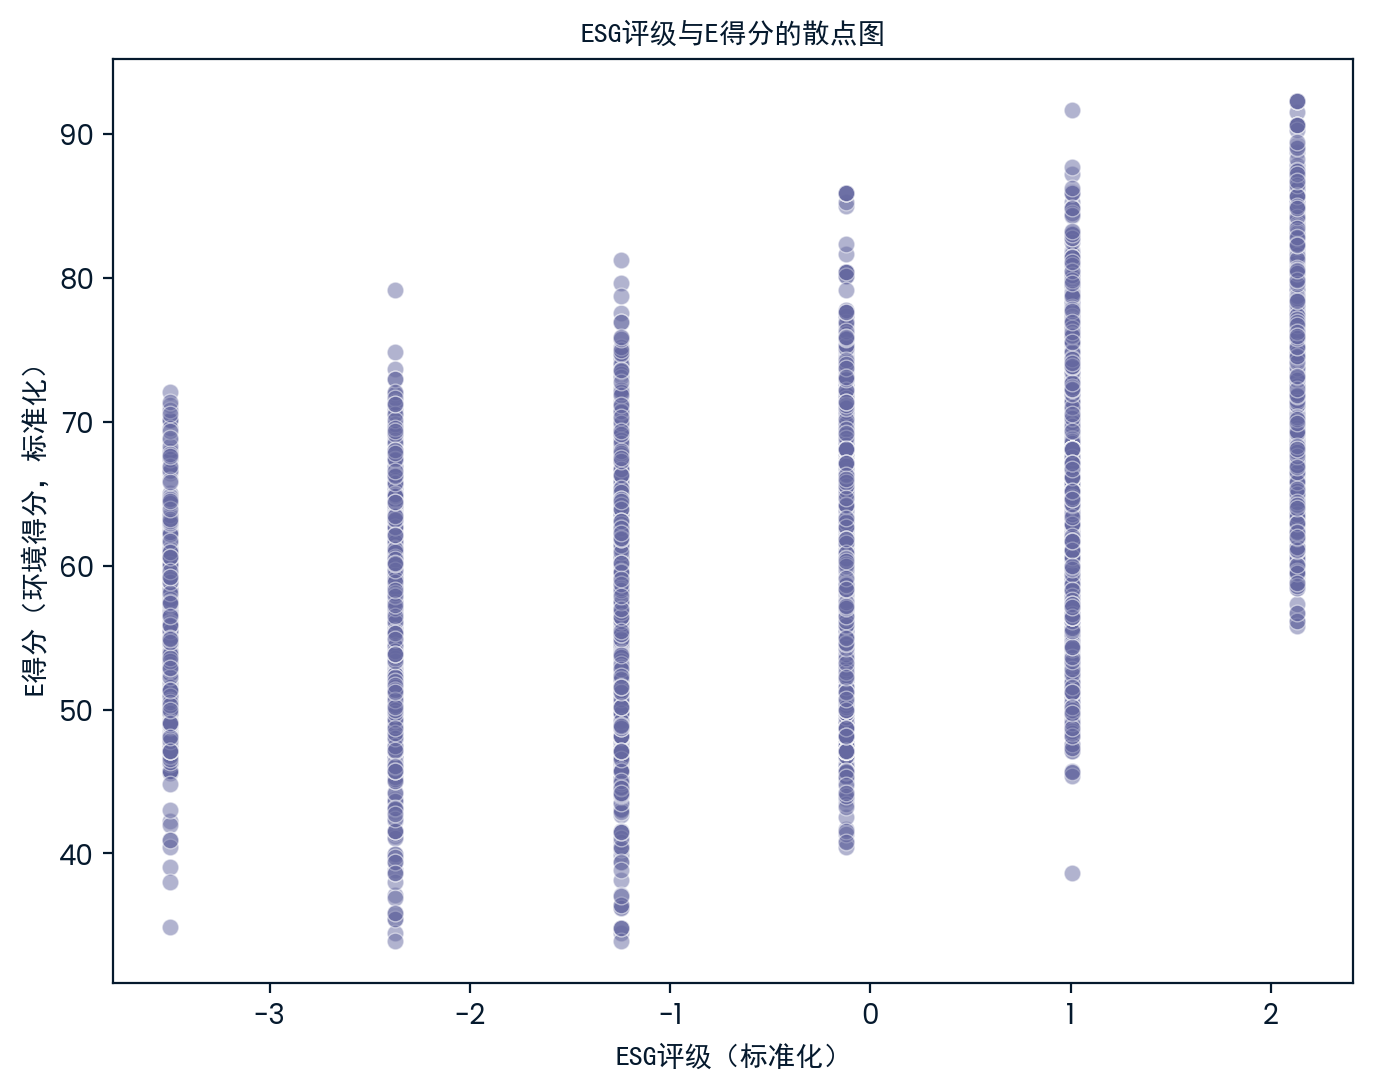

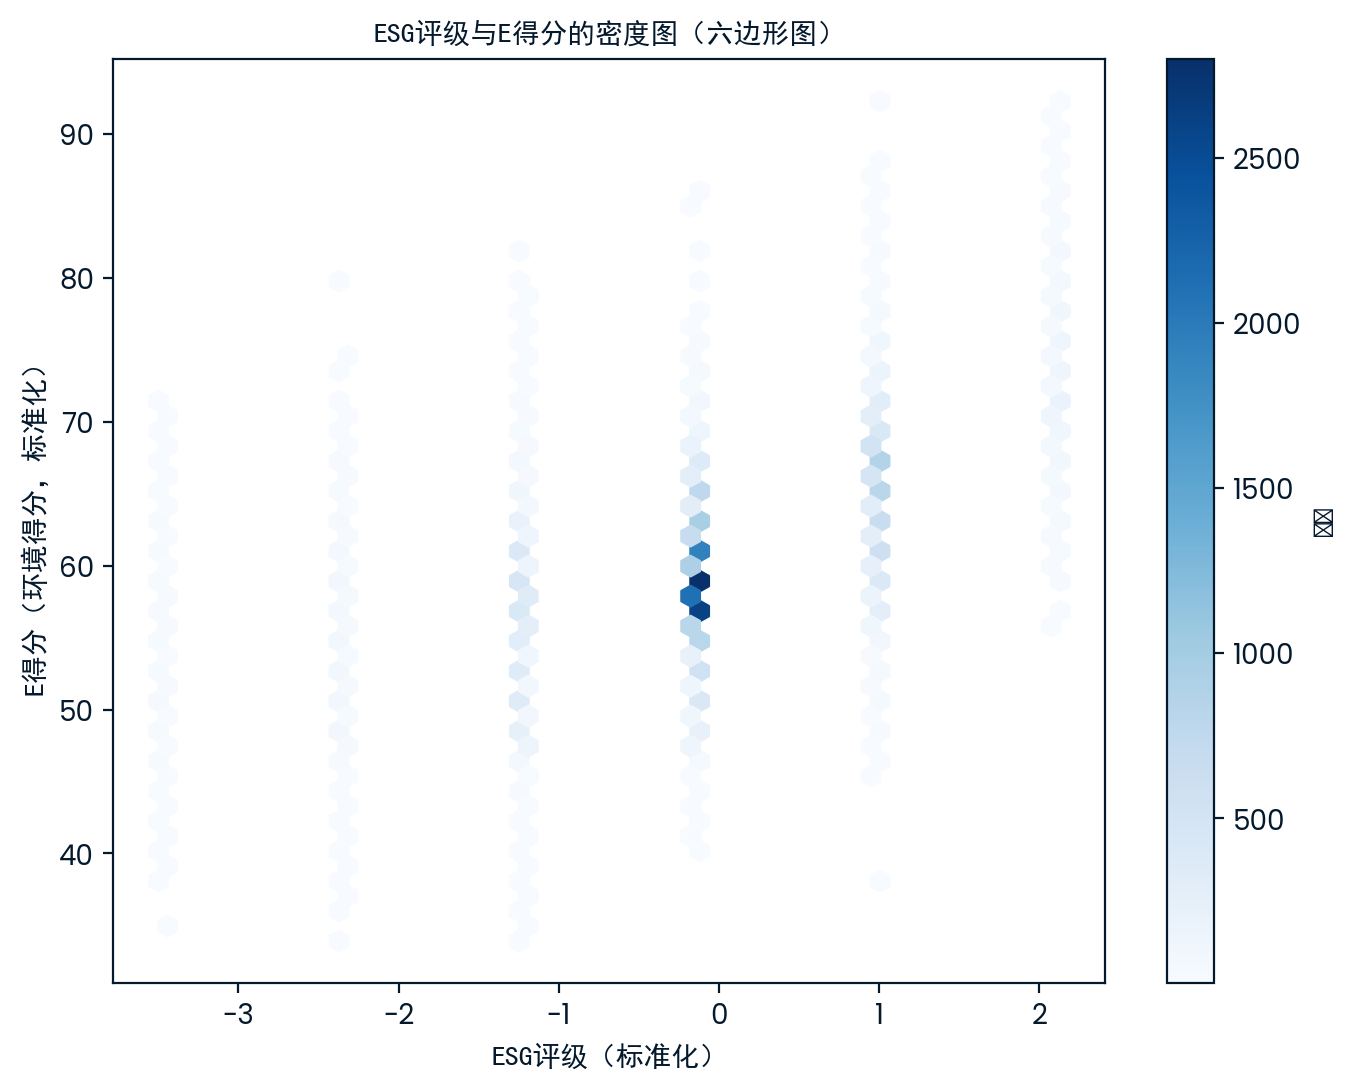

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm

# 设置字体以支持中文字符
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 加载预处理后的数据集（如果尚未加载）
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')

# 检查 ESG 和 E得分 之间的相关性
print("Correlation between ESG and E得分:", data_mfg['ESG'].corr(data_mfg['E得分']))

# 绘制 ESG 与 E得分 的散点图，使用中文标签
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ESG', y='E得分', data=data_mfg, alpha=0.5)
plt.title("ESG评级与E得分的散点图", fontproperties=font_prop)
plt.xlabel("ESG评级（标准化）", fontproperties=font_prop)
plt.ylabel("E得分（环境得分，标准化）", fontproperties=font_prop)
plt.savefig('esg_vs_e_score.png')
plt.show()

# 可选：使用六边形图进行更好的密度可视化
plt.figure(figsize=(8, 6))
plt.hexbin(data_mfg['ESG'], data_mfg['E得分'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='计数')
plt.title("ESG评级与E得分的密度图（六边形图）", fontproperties=font_prop)
plt.xlabel("ESG评级（标准化）", fontproperties=font_prop)
plt.ylabel("E得分（环境得分，标准化）", fontproperties=font_prop)
plt.savefig('hexbin_esg_vs_e_score.png')
plt.show()

In [13]:
import pandas as pd

# 加载预处理后的数据集
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')

# 打印所有列名
print("Columns in the dataset:")
print(data_mfg.columns.tolist())

# 检查常见的公司标识列名
possible_firm_id_columns = ['Symbol', '证券简称', 'code', 'ListedCoID', 'SecurityID', 'PersonID']
firm_id_column = None
for col in possible_firm_id_columns:
    if col in data_mfg.columns:
        unique_count = data_mfg[col].nunique()
        total_rows = len(data_mfg)
        print(f"Column {col}: {unique_count} unique values out of {total_rows} rows")
        if unique_count == total_rows / data_mfg['年份'].nunique():
            firm_id_column = col
            print(f"Found firm identifier column: {col} (unique per firm across years)")
            break

# 检查年份列
possible_year_columns = ['year', 'Year', '年度', '年份']
year_column = None
for col in possible_year_columns:
    if col in data_mfg.columns:
        year_column = col
        print(f"Found year column: {col}")
        break

if not firm_id_column:
    print("No firm identifier column found in the dataset.")
if not year_column:
    print("No year column found in the dataset.")
else:
    # 显示唯一年份和唯一公司数量
    print(f"Unique values in {year_column}:")
    print(sorted(data_mfg[year_column].unique()))
    if firm_id_column:
        print(f"Number of unique firms: {data_mfg[firm_id_column].nunique()}")

Columns in the dataset:
['Symbol', '年份', '行业', '总排放量吨', '营业收入万元', '碳强度', '营业成本万元', '碳绩效', '证券简称', '评级日期', 'Unnamed: 3', '综合评级', '综合得分', 'E评级', 'E得分', 'S评级', 'S得分', 'G评级', 'G得分', '证监会行业(新)', '同花顺行业(新)', '申万行业', '行业名称', '省份', '城市', '省份代码', '上市状态', '赫芬达尔指数', '勒纳指数', 'Unnamed: 10', 'Indcd', 'Indnme', 'F010101A', 'F010201A', 'F010401A', 'F011201A', 'B001101000', 'B001209000', 'B001210000', 'B001216000', 'B001000000', 'B002000000', 'F080602A', 'F081002B', 'F081602C', 'F050201B', 'F050501B', 'F051301B', 'F051701B', 'F051801B', 'F051901B', 'F052101B', 'F100101B', 'F100401A', 'F100901A', 'Boardsize', 'IndDirectorRatio', 'code', '上市日期', '成立日期', '行业代码', '行业名称_high_pollution', '是否重污染/高污染行业', 'PersonID', 'Name', 'IsMTB', 'A001101000', 'A001111000', 'A001100000', 'A001212000', 'A001000000', 'A002100000', 'A002000000', 'EndDate', 'ListedCoID', 'SecurityID', 'IndustryCode', 'IndustryNameC', 'IndustryCodeC', 'RegisterAddress', 'Zipcode', 'EstablishDate', 'Crcd', 'RegisterCapital', 'LISTINGDATE', 'PROVI

In [14]:
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体以支持中文字符
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载预处理后的数据集
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')

# 使用 Symbol 作为公司标识
firm_id_column = 'Symbol'
print(f"Using {firm_id_column} as the firm identifier.")
print(f"Number of unique firms: {data_mfg[firm_id_column].nunique()}")

# 将标准化的年份映射回原始年份 (2010-2023)
min_year, max_year = 2010, 2023
standardized_years = data_mfg['年份']
min_std, max_std = standardized_years.min(), standardized_years.max()
data_mfg['original_year'] = min_year + (standardized_years - min_std) * (max_year - min_year) / (max_std - min_std)
data_mfg['original_year'] = data_mfg['original_year'].round().astype(int)
year_column = 'original_year'

print("Mapped standardized 年份 to original years:")
print(sorted(data_mfg[year_column].unique()))

# 按公司和年份排序数据
data_mfg = data_mfg.sort_values([firm_id_column, year_column])
data_mfg['lagged_ESG'] = data_mfg.groupby(firm_id_column)['ESG'].shift(1)

# 删除 lagged_ESG 为 NaN 的行
data_mfg = data_mfg.dropna(subset=['lagged_ESG'])
print("Dataset shape after creating lagged_ESG and dropping NaNs:", data_mfg.shape)

# 准备 DML 数据，使用 lagged_ESG 作为处理变量
data_dml = dml.DoubleMLData(
    data_mfg,
    y_col='log_碳强度',
    d_cols='lagged_ESG',
    x_cols=['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']
)

# 使用随机森林运行 DML（2:1 分割比例）
dml_plr_rf = dml.DoubleMLPLR(
    data_dml,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf.fit()
ci = dml_plr_rf.confint()
print(f"ATE with lagged ESG: {dml_plr_rf.coef[0]:.4f}")
print(f"Confidence Interval: [{ci.iloc[0, 0]:.4f}, {ci.iloc[0, 1]:.4f}]")

Using Symbol as the firm identifier.
Number of unique firms: 2920
Mapped standardized 年份 to original years:
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Dataset shape after creating lagged_ESG and dropping NaNs: (30323, 103)
ATE with lagged ESG: 0.0159
Confidence Interval: [0.0102, 0.0217]


Unique values in 行业代码:
['I64' 'F51' 'H61' 'C37' 'C30' 'C39' 'E47' 'C41' 'C36' 'C33' 'C17' 'S90'
 'C13' 'C38' 'C25' 'C32' 'C27' 'C35' 'D44' 'C28' 'C26' 'C34' nan 'C22'
 'K70' 'C15' 'F52' 'I63' 'C29' 'C31' 'B08' 'A02' 'C21' 'C23' 'B09' 'C14'
 'A01' 'C40' 'C18' 'C20' 'N78' 'E49' 'G58' 'C24' 'E50' 'E48' 'L72' 'O81'
 'C19' 'I65' 'C42' 'B11' 'M74' 'C43' 'N77' 'A03' 'A05' 'A04' 'R87' 'G54'
 'B06']
Number of unique industries: 60

Running DML for industry: I64
Skipping industry I64 due to insufficient data (68 rows)

Running DML for industry: F51
Skipping industry F51 due to insufficient data (61 rows)

Running DML for industry: H61
Skipping industry H61 due to insufficient data (3 rows)

Running DML for industry: C37
ATE for industry C37: -0.0220
Confidence Interval: [-0.0673, 0.0234]

Running DML for industry: C30
ATE for industry C30: 0.0191
Confidence Interval: [-0.0142, 0.0523]

Running DML for industry: C39
ATE for industry C39: -0.0028
Confidence Interval: [-0.0144, 0.0088]

Running DML

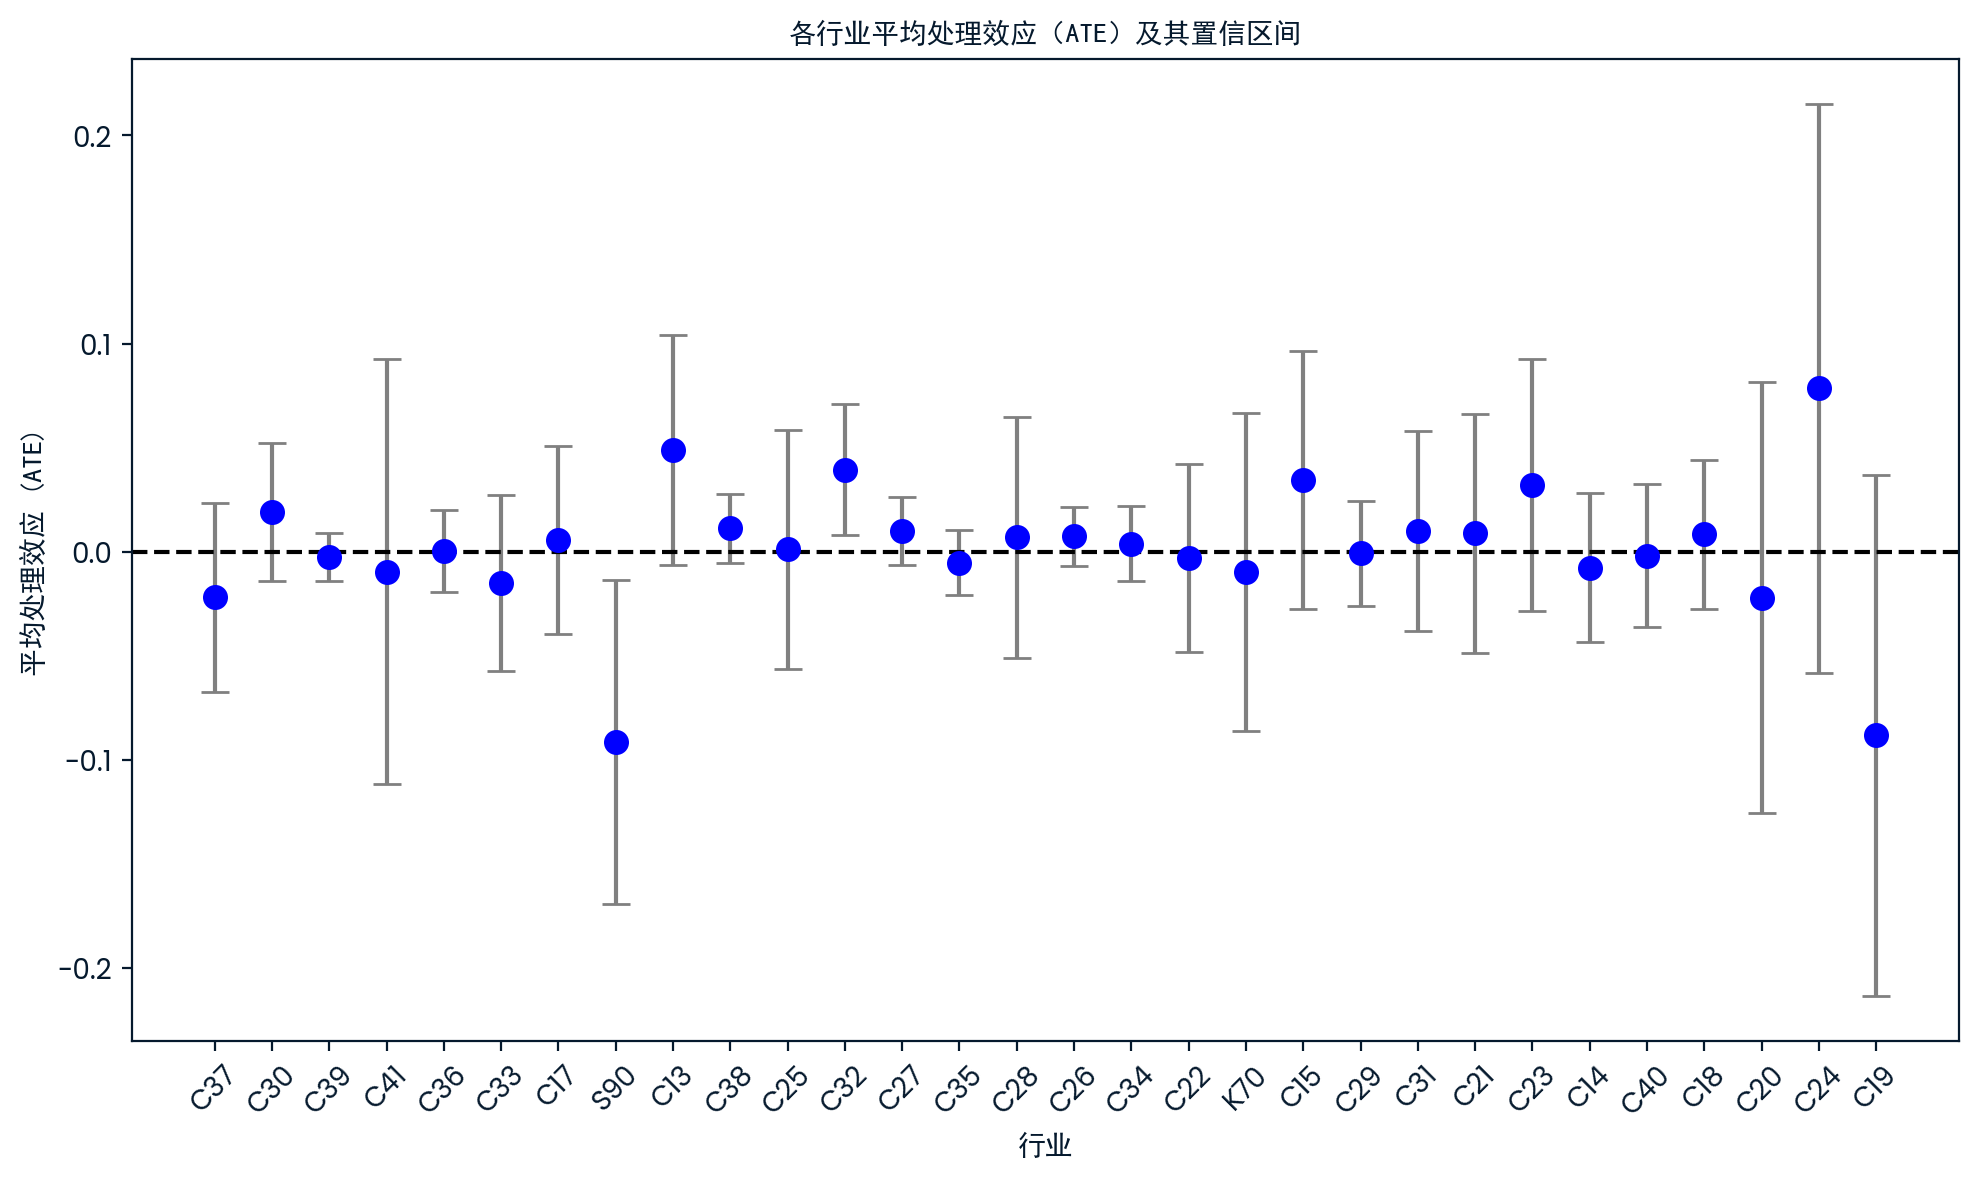

In [17]:
# 设置字体以支持中文字符
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 使用 行业代码 作为行业列
industry_column = '行业代码'

# 检查唯一行业
print(f"Unique values in {industry_column}:")
print(data_mfg[industry_column].unique())
print(f"Number of unique industries: {data_mfg[industry_column].nunique()}")

# 为每个行业运行 DML
industries = data_mfg[industry_column].unique()
ate_results_industry = []
ci_lower_results_industry = []
ci_upper_results_industry = []
industry_names = []

for industry in industries:
    print(f"\nRunning DML for industry: {industry}")
    industry_data = data_mfg[data_mfg[industry_column] == industry]
    if len(industry_data) < 100:
        print(f"Skipping industry {industry} due to insufficient data ({len(industry_data)} rows)")
        continue

    data_dml_industry = dml.DoubleMLData(
        industry_data,
        y_col='log_碳强度',
        d_cols='ESG',
        x_cols=['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']
    )

    dml_plr_rf = dml.DoubleMLPLR(
        data_dml_industry,
        ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        n_folds=5,
        n_rep=2
    )
    dml_plr_rf.fit()
    ci = dml_plr_rf.confint()
    print(f"ATE for industry {industry}: {dml_plr_rf.coef[0]:.4f}")
    print(f"Confidence Interval: [{ci.iloc[0, 0]:.4f}, {ci.iloc[0, 1]:.4f}]")

    ate_results_industry.append(dml_plr_rf.coef[0])
    ci_lower_results_industry.append(ci.iloc[0, 0])
    ci_upper_results_industry.append(ci.iloc[0, 1])
    industry_names.append(industry)

# 绘制各行业的 ATE
plt.figure(figsize=(10, 6))
lower_errors = [ate - ci_lower_results_industry[i] for i, ate in enumerate(ate_results_industry)]
upper_errors = [ci_upper_results_industry[i] - ate for i, ate in enumerate(ate_results_industry)]
plt.errorbar(industry_names, ate_results_industry, yerr=[lower_errors, upper_errors],
             fmt='o', capsize=5, color='blue', ecolor='gray', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.title("各行业平均处理效应（ATE）及其置信区间", fontproperties=font_prop)
plt.xlabel("行业", fontproperties=font_prop)
plt.ylabel("平均处理效应 (ATE)", fontproperties=font_prop)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ate_by_industry.png')
plt.show()

Distribution of ESG groups:
ESG_group
Medium (3-6)    20374
High (7-9)       6968
Other            2981
Name: count, dtype: int64

Running DML for ESG group: Low (1-2)
Skipping group Low (1-2) due to insufficient data (0 rows)

Running DML for ESG group: Medium (3-6)
ATE for group Medium (3-6): 0.0052
Confidence Interval: [-0.0120, 0.0225]

Running DML for ESG group: High (7-9)
ATE for group High (7-9): -166990862184.6917
Confidence Interval: [-604274759059.2175, 270293034689.8341]


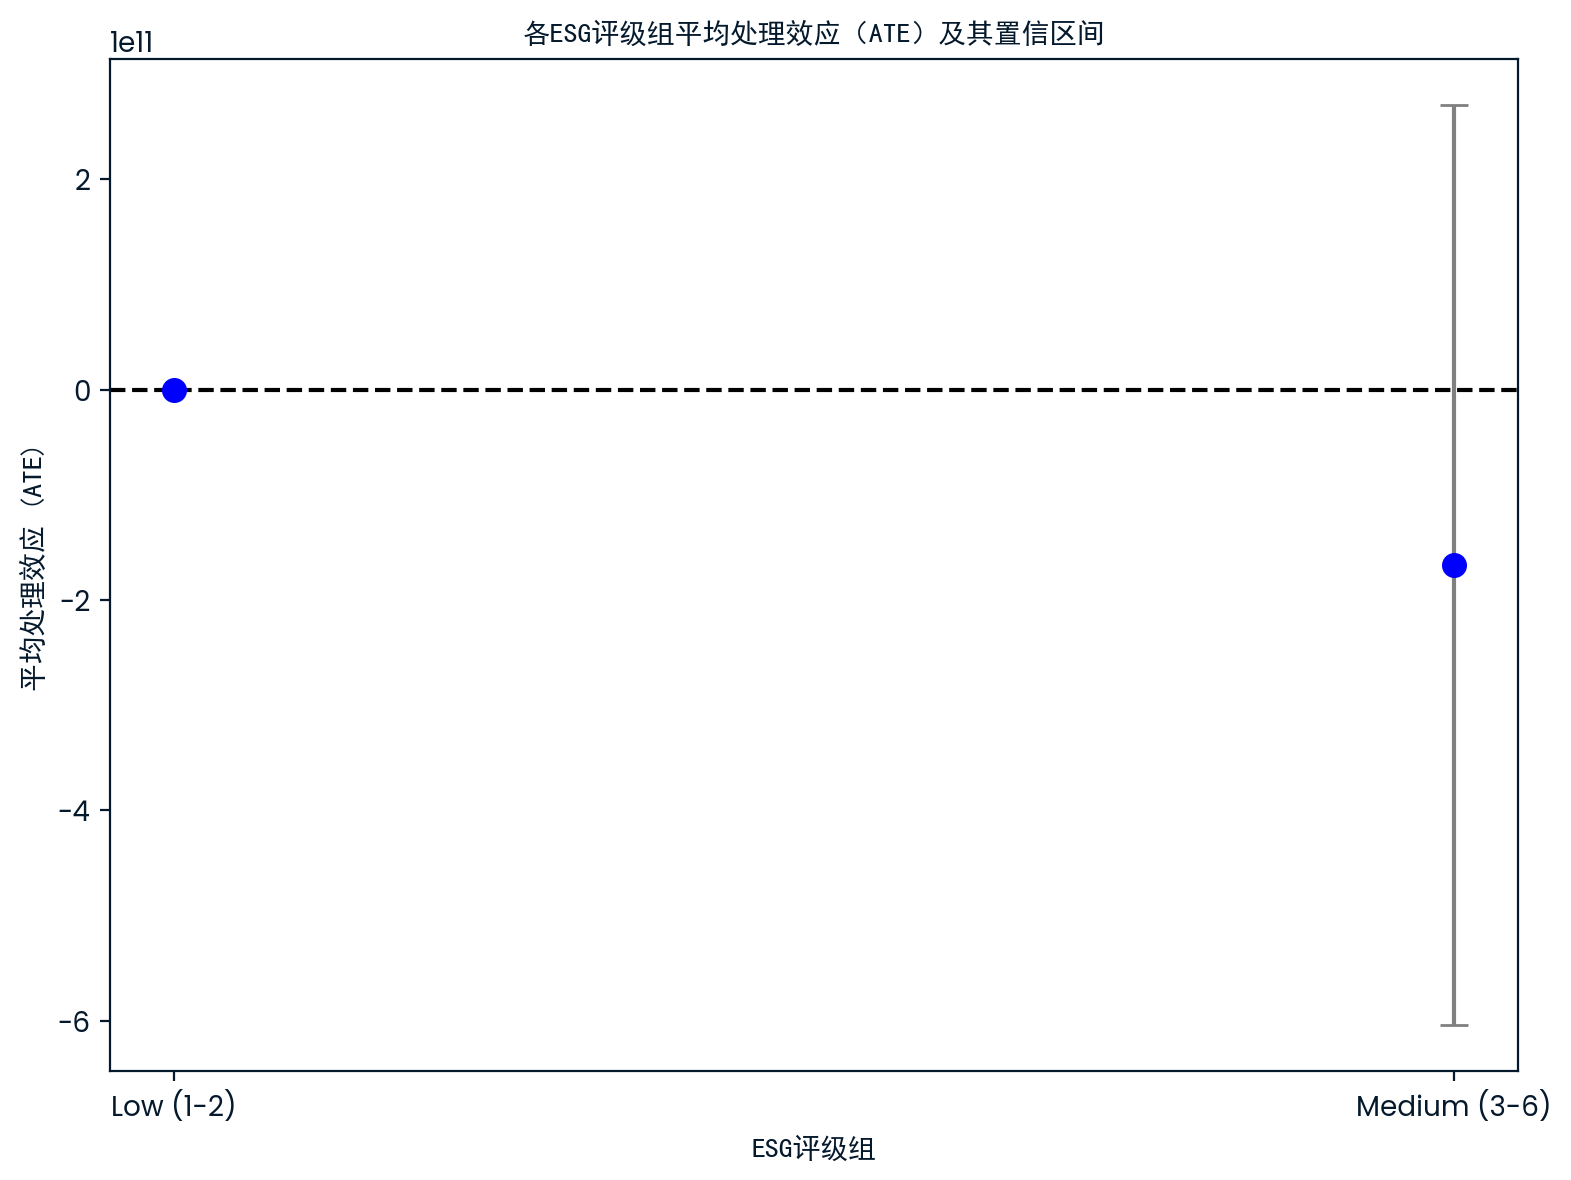

In [18]:

# 设置字体以支持中文字符
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 将标准化的 ESG 映射回原始的 1-9 评分范围
def map_esg_to_original(standardized_esg):
    return 1 + (standardized_esg + 3) * (9 - 1) / (2 + 3)  # Maps -3 to 1, 2 to 9

data_mfg['ESG_original'] = data_mfg['ESG'].apply(map_esg_to_original)

# 创建 ESG 评级组
def categorize_esg(esg):
    if 1 <= esg <= 2:
        return 'Low (1-2)'
    elif 3 <= esg <= 6:
        return 'Medium (3-6)'
    elif 7 <= esg <= 9:
        return 'High (7-9)'
    else:
        return 'Other'

data_mfg['ESG_group'] = data_mfg['ESG_original'].apply(categorize_esg)

# 检查 ESG 评级组的分布
print("Distribution of ESG groups:")
print(data_mfg['ESG_group'].value_counts())

# 为每个 ESG 评级组运行 DML
esg_groups = ['Low (1-2)', 'Medium (3-6)', 'High (7-9)']
ate_results = []
ci_lower_results = []
ci_upper_results = []

for group in esg_groups:
    print(f"\nRunning DML for ESG group: {group}")
    group_data = data_mfg[data_mfg['ESG_group'] == group]
    if len(group_data) < 100:
        print(f"Skipping group {group} due to insufficient data ({len(group_data)} rows)")
        continue

    data_dml_group = dml.DoubleMLData(
        group_data,
        y_col='log_碳强度',
        d_cols='ESG',
        x_cols=['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']
    )

    dml_plr_rf = dml.DoubleMLPLR(
        data_dml_group,
        ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        n_folds=5,
        n_rep=2
    )
    dml_plr_rf.fit()
    ci = dml_plr_rf.confint()
    print(f"ATE for group {group}: {dml_plr_rf.coef[0]:.4f}")
    print(f"Confidence Interval: [{ci.iloc[0, 0]:.4f}, {ci.iloc[0, 1]:.4f}]")

    ate_results.append(dml_plr_rf.coef[0])
    ci_lower_results.append(ci.iloc[0, 0])
    ci_upper_results.append(ci.iloc[0, 1])

# Plot ATE by ESG group
plt.figure(figsize=(8, 6))
lower_errors = [ate - ci_lower_results[i] for i, ate in enumerate(ate_results)]
upper_errors = [ci_upper_results[i] - ate for i, ate in enumerate(ate_results)]
plt.errorbar(esg_groups[:len(ate_results)], ate_results, yerr=[lower_errors, upper_errors],
             fmt='o', capsize=5, color='blue', ecolor='gray', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.title("各ESG评级组平均处理效应（ATE）及其置信区间", fontproperties=font_prop)
plt.xlabel("ESG评级组", fontproperties=font_prop)
plt.ylabel("平均处理效应 (ATE)", fontproperties=font_prop)
plt.tight_layout()
plt.savefig('ate_by_esg_group.png')
plt.show()

In [22]:
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据集
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')

# 根据唯一值定义调整后的映射
def map_esg_to_original_adjusted(standardized_esg):
    if standardized_esg == -3.498520825383155:
        return 1
    elif standardized_esg == -2.372573725915508:
        return 2
    elif standardized_esg == -1.246626626447861:
        return 3
    elif standardized_esg == -0.1206795269802135:
        return 4
    elif standardized_esg == 1.005267572487434:
        return 5
    elif standardized_esg == 2.131214671955081:
        return 7
    else:
        return None  # 处理意外值

# 应用调整后的映射
data_mfg['ESG_original'] = data_mfg['ESG'].apply(map_esg_to_original_adjusted)

# 重新创建 ESG 评级组
def categorize_esg(esg):
    if 1 <= esg <= 2:
        return 'Low (1-2)'
    elif 3 <= esg <= 6:
        return 'Medium (3-6)'
    elif 7 <= esg <= 9:
        return 'High (7-9)'
    else:
        return 'Other'

data_mfg['ESG_group'] = data_mfg['ESG_original'].apply(categorize_esg)

# 检查新的分布
print("Adjusted distribution of ESG groups:")
print(data_mfg['ESG_group'].value_counts())

Adjusted distribution of ESG groups:
ESG_group
Medium (3-6)    30124
High (7-9)       1752
Low (1-2)        1367
Name: count, dtype: int64



Running DML for ESG group: Low (1-2)
ATE for group Low (1-2): -0.0487
Confidence Interval: [-0.1064, 0.0090]

Running DML for ESG group: Medium (3-6)
ATE for group Medium (3-6): 0.0203
Confidence Interval: [0.0118, 0.0288]

Running DML for ESG group: High (7-9)
ATE for group High (7-9): -174282001152.9496
Confidence Interval: [-1916079655975.0305, 1567515653669.1311]


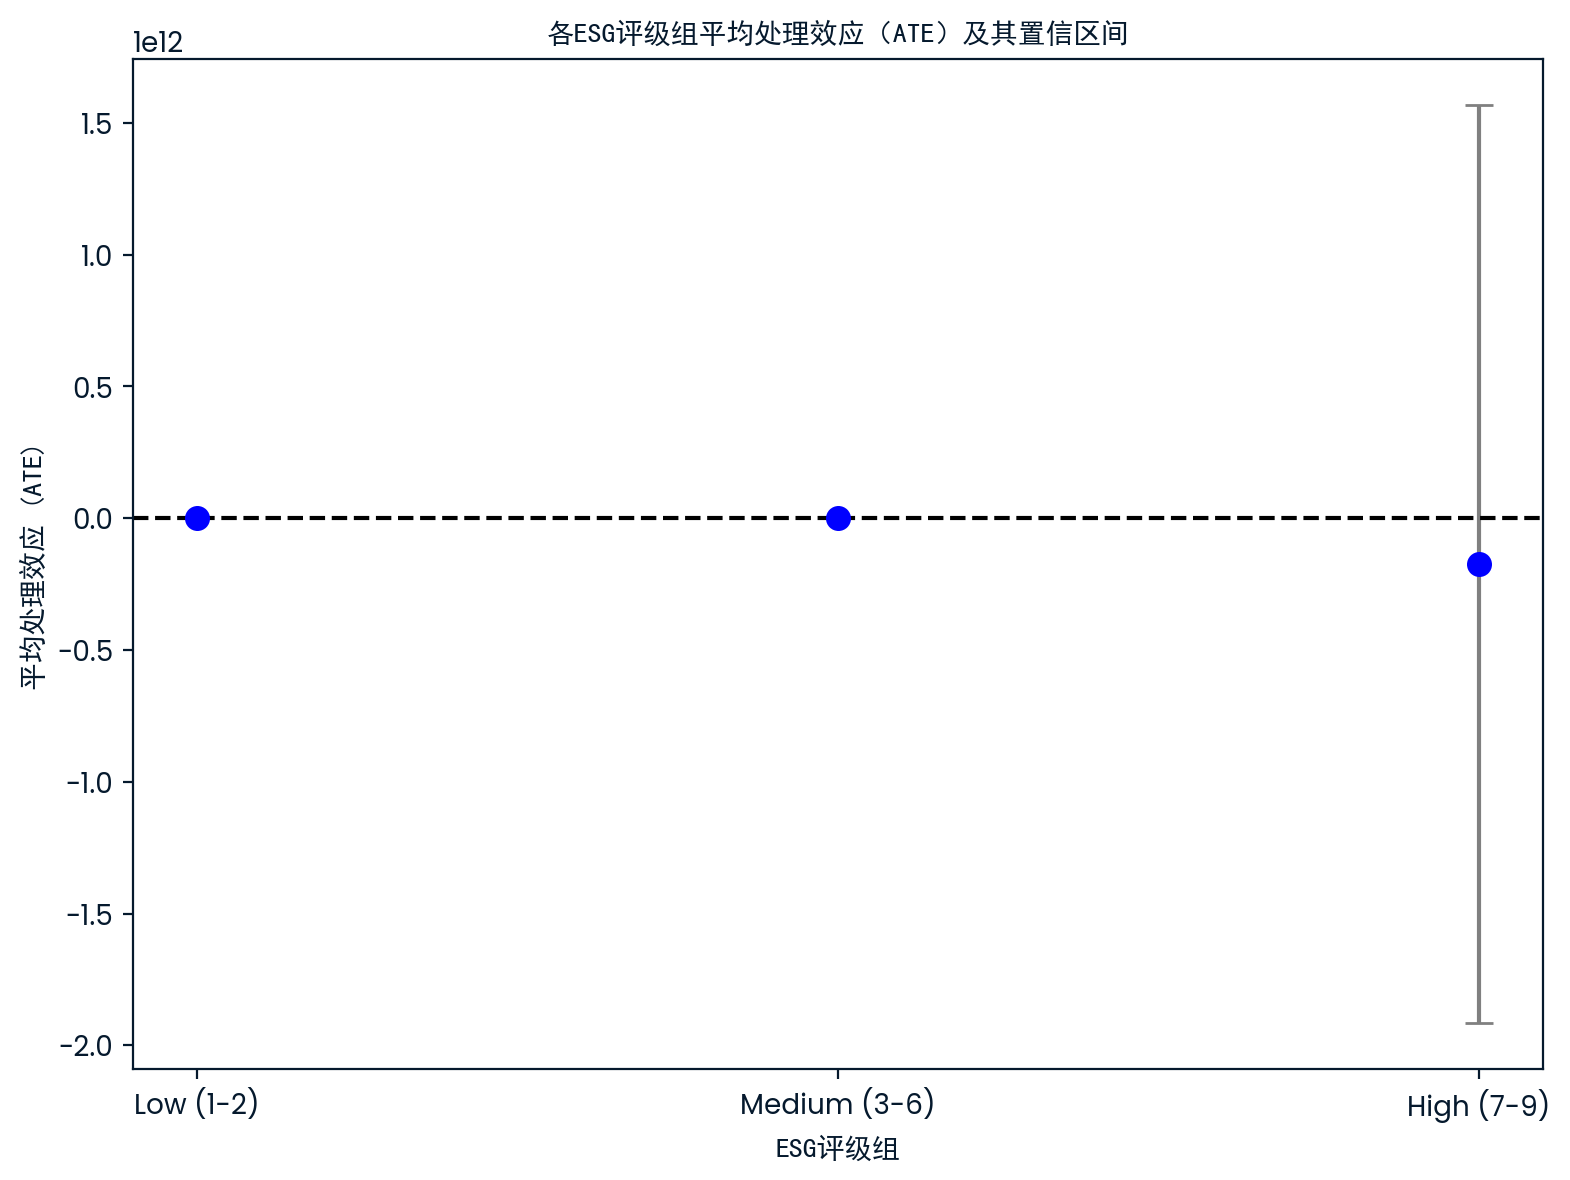

In [23]:
# 设置支持中文字符的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 为每个 ESG 评级组运行 DML
esg_groups = ['Low (1-2)', 'Medium (3-6)', 'High (7-9)']
ate_results = []
ci_lower_results = []
ci_upper_results = []

for group in esg_groups:
    print(f"\nRunning DML for ESG group: {group}")
    group_data = data_mfg[data_mfg['ESG_group'] == group]
    if len(group_data) < 100:
        print(f"Skipping group {group} due to insufficient data ({len(group_data)} rows)")
        continue

    data_dml_group = dml.DoubleMLData(
        group_data,
        y_col='log_碳强度',
        d_cols='ESG',
        x_cols=['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']
    )

    dml_plr_rf = dml.DoubleMLPLR(
        data_dml_group,
        ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        n_folds=5,
        n_rep=2
    )
    dml_plr_rf.fit()
    ci = dml_plr_rf.confint()
    print(f"ATE for group {group}: {dml_plr_rf.coef[0]:.4f}")
    print(f"Confidence Interval: [{ci.iloc[0, 0]:.4f}, {ci.iloc[0, 1]:.4f}]")

    ate_results.append(dml_plr_rf.coef[0])
    ci_lower_results.append(ci.iloc[0, 0])
    ci_upper_results.append(ci.iloc[0, 1])

# 绘制各ESG组的ATE图
plt.figure(figsize=(8, 6))
lower_errors = [ate - ci_lower_results[i] for i, ate in enumerate(ate_results)]
upper_errors = [ci_upper_results[i] - ate for i, ate in enumerate(ate_results)]
plt.errorbar(esg_groups[:len(ate_results)], ate_results, yerr=[lower_errors, upper_errors],
             fmt='o', capsize=5, color='blue', ecolor='gray', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.title("各ESG评级组平均处理效应（ATE）及其置信区间", fontproperties=font_prop)
plt.xlabel("ESG评级组", fontproperties=font_prop)
plt.ylabel("平均处理效应 (ATE)", fontproperties=font_prop)
plt.tight_layout()
plt.savefig('ate_by_esg_group_adjusted.png')
plt.show()


Running DML for ESG group: Low (1-2)
ATE for group Low (1-2): -0.0520
Confidence Interval: [-0.1087, 0.0048]

Running DML for ESG group: Medium (3-6)
ATE for group Medium (3-6): 0.0205
Confidence Interval: [0.0120, 0.0290]

Running DML for ESG group: High (7-9)
ATE for group High (7-9): -130567400388.5578
Confidence Interval: [-1871630167283.4004, 1610495366506.2847]


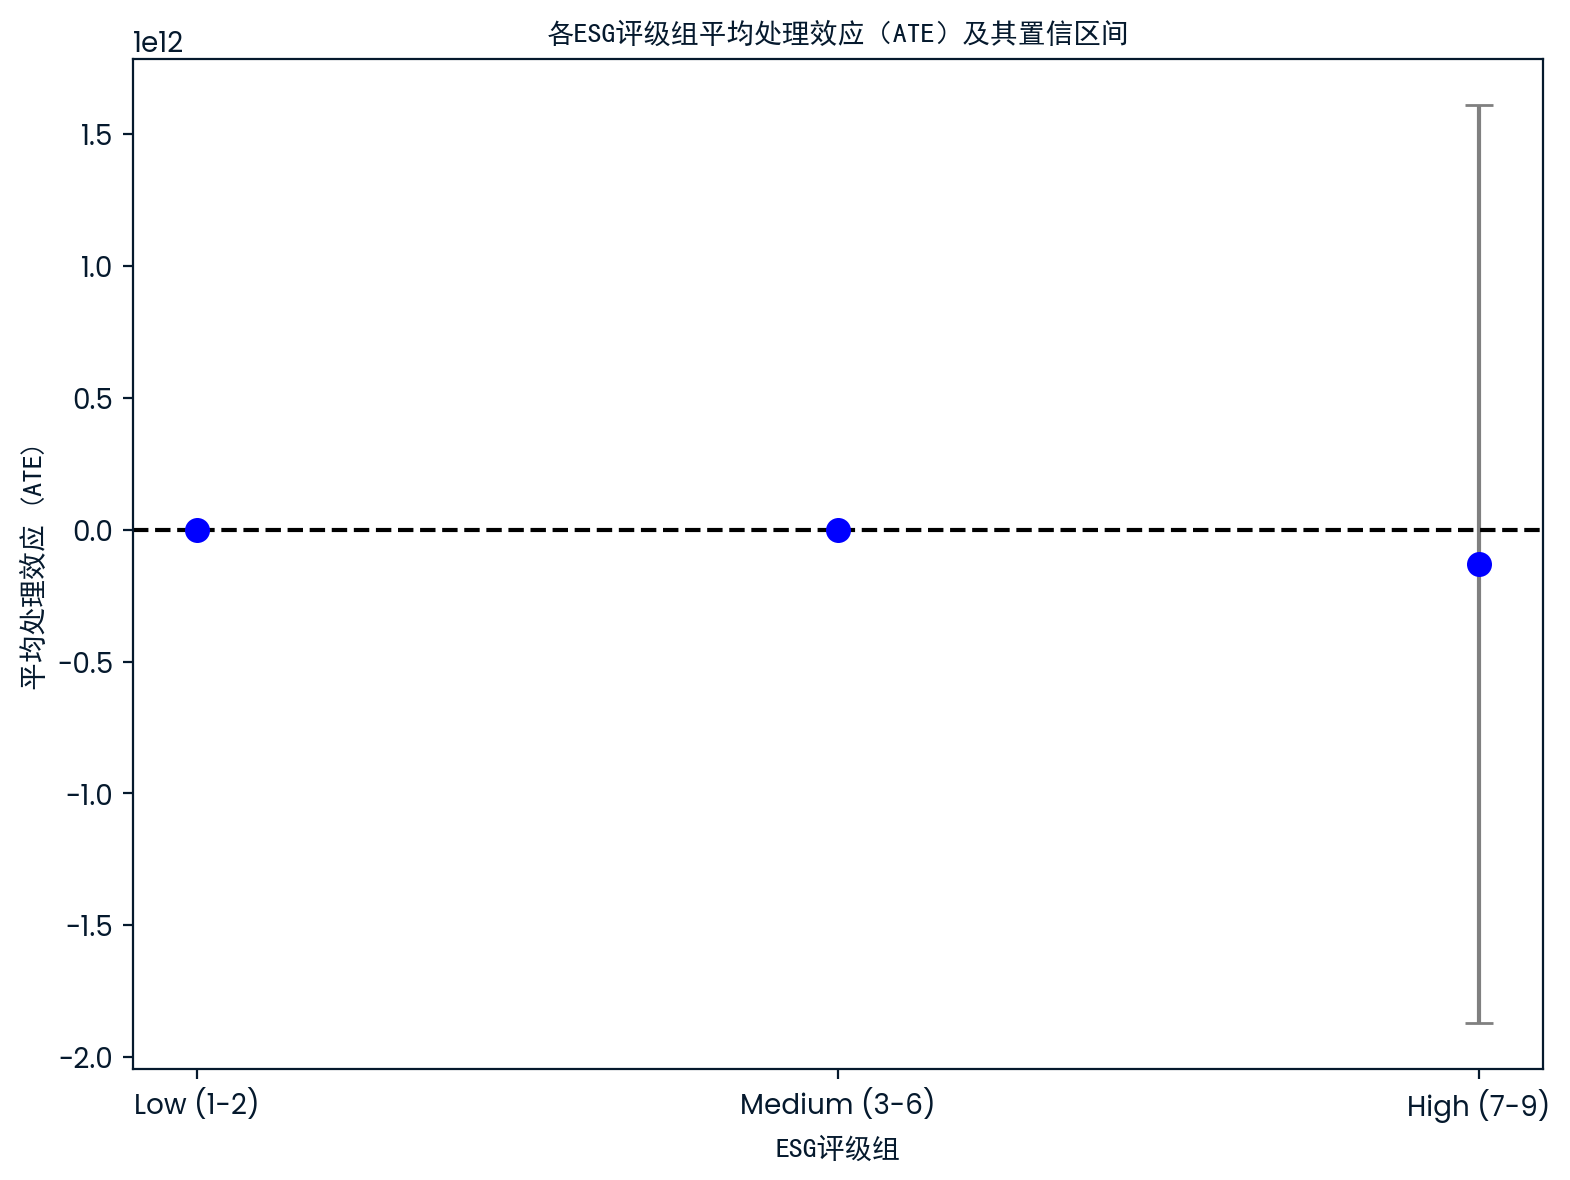

In [24]:
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import matplotlib.font_manager as fm

font_path = 'SimHei.ttf' 
font_prop = fm.FontProperties(fname=font_path)

# 加载数据集
data_mfg = pd.read_excel('data_mfg_preprocessed.xlsx')

# 定义调整后的ESG映射函数
def map_esg_to_original_adjusted(standardized_esg):
    if standardized_esg == -3.498520825383155:
        return 1
    elif standardized_esg == -2.372573725915508:
        return 2
    elif standardized_esg == -1.246626626447861:
        return 3
    elif standardized_esg == -0.1206795269802135:
        return 4
    elif standardized_esg == 1.005267572487434:
        return 5
    elif standardized_esg == 2.131214671955081:
        return 7
    else:
        return None

data_mfg['ESG_original'] = data_mfg['ESG'].apply(map_esg_to_original_adjusted)

# 重新创建ESG分组
def categorize_esg(esg):
    if 1 <= esg <= 2:
        return 'Low (1-2)'
    elif 3 <= esg <= 6:
        return 'Medium (3-6)'
    elif 7 <= esg <= 9:
        return 'High (7-9)'
    else:
        return 'Other'

data_mfg['ESG_group'] = data_mfg['ESG_original'].apply(categorize_esg)

# 对整个数据集的log_碳强度进行Winsorize处理
data_mfg['log_碳强度_winsorized'] = winsorize(data_mfg['log_碳强度'], limits=[0.01, 0.01])

# 设置支持中文字符的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 为每个ESG组使用Winsorize后的数据运行DML分析
esg_groups = ['Low (1-2)', 'Medium (3-6)', 'High (7-9)']
ate_results = []
ci_lower_results = []
ci_upper_results = []

for group in esg_groups:
    print(f"\nRunning DML for ESG group: {group}")
    group_data = data_mfg[data_mfg['ESG_group'] == group]
    if len(group_data) < 100:
        print(f"Skipping group {group} due to insufficient data ({len(group_data)} rows)")
        continue

    data_dml_group = dml.DoubleMLData(
        group_data,
        y_col='log_碳强度_winsorized',
        d_cols='ESG',
        x_cols=['Size', 'ROA', 'Lev', 'log_Boardsize', '赫芬达尔指数', 'IndDirectorRatio', 'F051901B', 'GDP', '环保规制强度']
    )

    dml_plr_rf = dml.DoubleMLPLR(
        data_dml_group,
        ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        n_folds=5,
        n_rep=2
    )
    dml_plr_rf.fit()
    ci = dml_plr_rf.confint()
    print(f"ATE for group {group}: {dml_plr_rf.coef[0]:.4f}")
    print(f"Confidence Interval: [{ci.iloc[0, 0]:.4f}, {ci.iloc[0, 1]:.4f}]")

    ate_results.append(dml_plr_rf.coef[0])
    ci_lower_results.append(ci.iloc[0, 0])
    ci_upper_results.append(ci.iloc[0, 1])

# 绘制各ESG组的ATE图
plt.figure(figsize=(8, 6))
lower_errors = [ate - ci_lower_results[i] for i, ate in enumerate(ate_results)]
upper_errors = [ci_upper_results[i] - ate for i, ate in enumerate(ate_results)]
plt.errorbar(esg_groups[:len(ate_results)], ate_results, yerr=[lower_errors, upper_errors],
             fmt='o', capsize=5, color='blue', ecolor='gray', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.title("各ESG评级组平均处理效应（ATE）及其置信区间", fontproperties=font_prop)
plt.xlabel("ESG评级组", fontproperties=font_prop)
plt.ylabel("平均处理效应 (ATE)", fontproperties=font_prop)
plt.tight_layout()
plt.savefig('ate_by_esg_group_winsorized.png')
plt.show()

In [25]:
# 检查高评级 (7-9) 组的数据
high_esg_data = data_mfg[data_mfg['ESG_group'] == 'High (7-9)']
print("Summary statistics for High (7-9) group:")
print(high_esg_data[['ESG', 'log_碳强度_winsorized', 'Size', 'ROA', 'Lev']].describe())

# 检查 ESG 的变异性
print("Unique ESG values in High (7-9) group:")
print(high_esg_data['ESG'].unique())

# 检查协变量中的异常值
print("Outliers in Size for High (7-9) group:")
print(high_esg_data[high_esg_data['Size'].abs() > 1e6])  # 根据需要调整阈值
print("Outliers in ROA for High (7-9) group:")
print(high_esg_data[high_esg_data['ROA'].abs() > 1])  # ROA 通常在 -1 到 1 之间
print("Outliers in Lev for High (7-9) group:")
print(high_esg_data[high_esg_data['Lev'].abs() > 2])  # Leverage typically ranges from 0 to 2

Summary statistics for High (7-9) group:
                ESG  log_碳强度_winsorized         Size          ROA          Lev
count  1.752000e+03         1752.000000  1752.000000  1752.000000  1752.000000
mean   2.131215e+00           -0.025154     0.748108     0.067262    -0.126655
std    4.442160e-16            0.940291     1.336966     1.057361     0.937369
min    2.131215e+00           -3.247514    -1.967526    -1.494467    -1.873871
25%    2.131215e+00           -0.097436    -0.272848    -0.675545    -0.915375
50%    2.131215e+00            0.298039     0.567572    -0.104908    -0.113867
75%    2.131215e+00            0.539420     1.777149     0.599244     0.624229
max    2.131215e+00            1.047717     4.796387     4.029575     2.106366
Unique ESG values in High (7-9) group:
[2.13121467]
Outliers in Size for High (7-9) group:
Empty DataFrame
Columns: [Symbol, 年份, 行业, 总排放量吨, 营业收入万元, 碳强度, 营业成本万元, 碳绩效, 证券简称, 评级日期, Unnamed: 3, 综合评级, 综合得分, E评级, E得分, S评级, S得分, G评级, G得分, 证监会行业(新), 同花顺行业(

In [26]:
# 比较各 ESG 组的平均 log_碳强度_winsorized
print("Average log_碳强度_winsorized by ESG group:")
print(data_mfg.groupby('ESG_group')['log_碳强度_winsorized'].mean())

Average log_碳强度_winsorized by ESG group:
ESG_group
High (7-9)     -0.025154
Low (1-2)       0.274670
Medium (3-6)   -0.011001
Name: log_碳强度_winsorized, dtype: float64


In [37]:
from scipy.stats.mstats import winsorize
import numpy as np

# 确保 log_碳强度 是数值型，并处理任何缺失值
data_mfg['log_碳强度'] = pd.to_numeric(data_mfg['log_碳强度'], errors='coerce')

# 对 log_碳强度 进行 Winsorize 处理（限制上下 1% 以处理异常值）
data_mfg['log_碳强度_winsorized'] = winsorize(data_mfg['log_碳强度'], limits=[0.01, 0.01])

# 验证新列是否已添加
print("Columns after adding log_碳强度_winsorized:")
print(data_mfg.columns.tolist())



Columns after adding log_碳强度_winsorized:
['Symbol', '年份', '行业', '总排放量吨', '营业收入万元', '碳强度', '营业成本万元', '碳绩效', '证券简称', '评级日期', 'Unnamed: 3', '综合评级', '综合得分', 'E评级', 'E得分', 'S评级', 'S_Score', 'G评级', 'G_Score', '证监会行业(新)', '同花顺行业(新)', '申万行业', '行业名称', '省份', '城市', '省份代码', '上市状态', 'HerfindahlIndex', '勒纳指数', 'Unnamed: 10', 'Indcd', 'Indnme', 'F010101A', 'F010201A', 'F010401A', 'F011201A', 'B001101000', 'B001209000', 'B001210000', 'B001216000', 'B001000000', 'B002000000', 'F080602A', 'F081002B', 'F081602C', 'F050201B', 'F050501B', 'F051301B', 'F051701B', 'F051801B', 'F051901B', 'F052101B', 'F100101B', 'F100401A', 'F100901A', 'Boardsize', 'IndDirectorRatio', 'code', '上市日期', '成立日期', '行业代码', '行业名称_high_pollution', '是否重污染/高污染行业', 'PersonID', 'Name', 'IsMTB', 'A001101000', 'A001111000', 'A001100000', 'A001212000', 'A001000000', 'A002100000', 'A002000000', 'EndDate', 'ListedCoID', 'SecurityID', 'IndustryCode', 'IndustryNameC', 'IndustryCodeC', 'RegisterAddress', 'Zipcode', 'EstablishDate', 'Crcd', 'Regis

In [38]:
# 将 S_Score 和 G_Score 重命名为 S得分 和 G得分 以保持一致性
data_mfg = data_mfg.rename(columns={
    'S_Score': 'S得分',
    'G_Score': 'G得分'
})

# 验证更新后的列名
print("Columns after renaming S_Score and G_Score:")
print(data_mfg.columns.tolist())

Columns after renaming S_Score and G_Score:
['Symbol', '年份', '行业', '总排放量吨', '营业收入万元', '碳强度', '营业成本万元', '碳绩效', '证券简称', '评级日期', 'Unnamed: 3', '综合评级', '综合得分', 'E评级', 'E得分', 'S评级', 'S得分', 'G评级', 'G得分', '证监会行业(新)', '同花顺行业(新)', '申万行业', '行业名称', '省份', '城市', '省份代码', '上市状态', 'HerfindahlIndex', '勒纳指数', 'Unnamed: 10', 'Indcd', 'Indnme', 'F010101A', 'F010201A', 'F010401A', 'F011201A', 'B001101000', 'B001209000', 'B001210000', 'B001216000', 'B001000000', 'B002000000', 'F080602A', 'F081002B', 'F081602C', 'F050201B', 'F050501B', 'F051301B', 'F051701B', 'F051801B', 'F051901B', 'F052101B', 'F100101B', 'F100401A', 'F100901A', 'Boardsize', 'IndDirectorRatio', 'code', '上市日期', '成立日期', '行业代码', '行业名称_high_pollution', '是否重污染/高污染行业', 'PersonID', 'Name', 'IsMTB', 'A001101000', 'A001111000', 'A001100000', 'A001212000', 'A001000000', 'A002100000', 'A002000000', 'EndDate', 'ListedCoID', 'SecurityID', 'IndustryCode', 'IndustryNameC', 'IndustryCodeC', 'RegisterAddress', 'Zipcode', 'EstablishDate', 'Crcd', 'RegisterCa

In [39]:
# 定义 x_cols
x_cols = ['Size', 'ROA_winsorized', 'Lev_winsorized', 'log_Boardsize', 'HerfindahlIndex', 'IndDirectorRatio', 'F051901B', 'GDP', 'EnvRegulation']

# 检查特定列
print("Checking specific columns after renaming:")
for col in x_cols + ['log_碳强度_winsorized', 'S得分', 'G得分']:
    if col in data_mfg.columns:
        print(f"{col}: Found")
    else:
        print(f"{col}: Not found")

Checking specific columns after renaming:
Size: Found
ROA_winsorized: Found
Lev_winsorized: Found
log_Boardsize: Found
HerfindahlIndex: Found
IndDirectorRatio: Found
F051901B: Found
GDP: Found
EnvRegulation: Found
log_碳强度_winsorized: Found
S得分: Found
G得分: Found


In [40]:
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor

# 以 S得分为处理变量运行 DML
data_dml_s = dml.DoubleMLData(
    data_mfg,
    y_col='log_碳强度_winsorized',
    d_cols='S得分',
    x_cols=x_cols
)

dml_plr_rf_s = dml.DoubleMLPLR(
    data_dml_s,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_s.fit()
ci_s = dml_plr_rf_s.confint()
print(f"ATE with S得分: {dml_plr_rf_s.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_s.iloc[0, 0]:.4f}, {ci_s.iloc[0, 1]:.4f}]")

ATE with S得分: -0.0022
Confidence Interval: [-0.0029, -0.0016]


In [41]:
# 以 G得分为处理变量运行 DML
data_dml_g = dml.DoubleMLData(
    data_mfg,
    y_col='log_碳强度_winsorized',
    d_cols='G得分',
    x_cols=x_cols
)

dml_plr_rf_g = dml.DoubleMLPLR(
    data_dml_g,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_g.fit()
ci_g = dml_plr_rf_g.confint()
print(f"ATE with G得分: {dml_plr_rf_g.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_g.iloc[0, 0]:.4f}, {ci_g.iloc[0, 1]:.4f}]")

ATE with G得分: 0.0037
Confidence Interval: [0.0027, 0.0048]


In [42]:
# 筛选 C32 行业（化学制品行业）的数据
c32_data = data_mfg[data_mfg['行业代码'] == 'C32']

# 对 C32 行业以 ESG 作为处理变量运行 DML
data_dml_c32 = dml.DoubleMLData(
    c32_data,
    y_col='log_碳强度_winsorized',
    d_cols='ESG',
    x_cols=x_cols
)

dml_plr_rf_c32 = dml.DoubleMLPLR(
    data_dml_c32,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_c32.fit()
ci_c32 = dml_plr_rf_c32.confint()
print(f"ATE for C32 (ESG): {dml_plr_rf_c32.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_c32.iloc[0, 0]:.4f}, {ci_c32.iloc[0, 1]:.4f}]")

# 对 C32 行业以 E得分 作为处理变量运行 DML
data_dml_c32_e = dml.DoubleMLData(
    c32_data,
    y_col='log_碳强度_winsorized',
    d_cols='E得分',
    x_cols=x_cols
)

dml_plr_rf_c32_e = dml.DoubleMLPLR(
    data_dml_c32_e,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_c32_e.fit()
ci_c32_e = dml_plr_rf_c32_e.confint()
print(f"ATE for C32 (E得分): {dml_plr_rf_c32_e.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_c32_e.iloc[0, 0]:.4f}, {ci_c32_e.iloc[0, 1]:.4f}]")

# 对 C32 行业以 S得分 作为处理变量运行 DML
data_dml_c32_s = dml.DoubleMLData(
    c32_data,
    y_col='log_碳强度_winsorized',
    d_cols='S得分',
    x_cols=x_cols
)

dml_plr_rf_c32_s = dml.DoubleMLPLR(
    data_dml_c32_s,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_c32_s.fit()
ci_c32_s = dml_plr_rf_c32_s.confint()
print(f"ATE for C32 (S得分): {dml_plr_rf_c32_s.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_c32_s.iloc[0, 0]:.4f}, {ci_c32_s.iloc[0, 1]:.4f}]")

# 对 C32 行业以 G得分 作为处理变量运行 DML
data_dml_c32_g = dml.DoubleMLData(
    c32_data,
    y_col='log_碳强度_winsorized',
    d_cols='G得分',
    x_cols=x_cols
)

dml_plr_rf_c32_g = dml.DoubleMLPLR(
    data_dml_c32_g,
    ml_l=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    ml_m=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    n_folds=5,
    n_rep=2
)
dml_plr_rf_c32_g.fit()
ci_c32_g = dml_plr_rf_c32_g.confint()
print(f"ATE for C32 (G得分): {dml_plr_rf_c32_g.coef[0]:.4f}")
print(f"Confidence Interval: [{ci_c32_g.iloc[0, 0]:.4f}, {ci_c32_g.iloc[0, 1]:.4f}]")

ATE for C32 (ESG): 0.0317
Confidence Interval: [-0.0000, 0.0635]
ATE for C32 (E得分): -0.0026
Confidence Interval: [-0.0080, 0.0028]
ATE for C32 (S得分): 0.0012
Confidence Interval: [-0.0023, 0.0047]
ATE for C32 (G得分): 0.0074
Confidence Interval: [0.0001, 0.0146]
